In [1]:
import pandas as pd
from emle_bespoke.utils import create_dimer_topology
from openff.interchange import Interchange as _Interchange
from openff.toolkit import ForceField as _ForceField
import numpy as np
import openmm as mm
from emle.models import EMLE
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import torch
from emle_bespoke.lj_fitting import LennardJonesPotential as _LennardJonesPotential
import matplotlib.pyplot as plt
import seaborn as sns
from emle_bespoke.bespoke import BespokeModelTrainer as _BespokeModelTrainer
from collections import defaultdict
import numpy as np
import pickle
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds


/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
force_field = _ForceField("openff-2.0.0.offxml")

In [3]:
read = True
if read:
    with open("/home/joaomorado/repos/emle-bespoke/utils/DES370K-water.pkl", "rb") as f:
        results = pickle.load(f)
    with open("/home/joaomorado/repos/emle-bespoke/utils/dataset-water.pkl", "rb") as f:
        dataset = pickle.load(f)
    rg=1
else:
    #df = pd.read_csv('/home/joaomorado/repos/emle-bespoke/utils/DESS66x8.csv')
    #df = pd.read_csv('/home/joaomorado/repos/emle-bespoke/utils/DESS66x8.csv')
    df = pd.read_csv('/home/joaomorado/repos/emle-bespoke/utils/DES370K.csv')
    # Pre-allocate lists for results
    results = defaultdict(list)

    # Initialize force field and interchange object
    force_field = _ForceField("openff-2.0.0.offxml")

    # Get unique system IDs
    unique_ids = df["system_id"].unique()
    allowed_elements = ["H", "C", "N", "O", "S"]

    dataset = {}

    # Loop over unique IDs
    frame = 0
    for system_id in unique_ids:
        print(f"Processing system {system_id} out of {len(unique_ids)}")
        # Filter DataFrame for the current system ID
        df_filtered = df[df["system_id"] == system_id]
        smiles0, smiles1 = df_filtered.iloc[0][["smiles0", "smiles1"]]
        natoms0, natoms1 = df_filtered.iloc[0][["natoms0", "natoms1"]]
        charge0, charge1 = df_filtered.iloc[0][["charge0", "charge1"]]  
        elements = df_filtered.iloc[0]["elements"]

        # Create xyz
        #xyz = np.fromstring(df_filtered.iloc[0]["xyz"], sep=" ").reshape(-1, 3)
        

        if smiles0 != "O" and smiles1 != "O":
            continue

        if not all(elem in allowed_elements for elem in set(elements.split())):
            print(f"Skipping system {system_id} due to unsupported elements: {set(elements.split())}")
            continue
        if charge0 != 0 or charge1 != 0:
            print(f"Skipping system {system_id} due to non-zero charges: {charge0}, {charge1}")
            continue
        
        rg = 1
        for i in range(rg):
            if rg == 1:
                if smiles0 == "O":
                    i = 1
                else:
                    i = 0

            if i == 0:
                solute, solvent = smiles0, smiles1
                solute_idx = list(range(natoms0))
                solvent_idx = list(range(natoms0, natoms0 + natoms1))
            else:
                solute, solvent = smiles1, smiles0
                solute_idx = list(range(natoms0, natoms0 + natoms1))
                solvent_idx = list(range(natoms0))

            # Debugging print statement (optional)
            print(f"Processing system: {system_id}, Solute: {solute}, Solvent: {solvent}")

            xyz = np.fromstring(df_filtered.iloc[0]["xyz"], sep=" ").reshape(-1, 3)
            with open("solute.xyz", "w") as f:
                f.write(f"{len(solute_idx)}\n\n")
                for idx in solute_idx:
                    f.write(f"{elements.split()[idx]} {xyz[idx][0]:.6f} {xyz[idx][1]:.6f} {xyz[idx][2]:.6f}\n")
                    
            with open("solvent.xyz", "w") as f:
                f.write(f"{len(solvent_idx)}\n\n")
                for idx in solvent_idx:
                    f.write(f"{elements.split()[idx]} {xyz[idx][0]:.6f} {xyz[idx][1]:.6f} {xyz[idx][2]:.6f}\n")

            try:
                solute_mol = Chem.MolFromXYZFile('solute.xyz')
                mol = Chem.Mol(solute_mol)
                rdDetermineBonds.DetermineBonds(mol,charge=0)
                for i, atom in enumerate(mol.GetAtoms()):
                    atom.SetAtomMapNum(i + 1) 
                solute = Chem.MolToSmiles(mol)
            except:
                print(f"MolFromXYZFile Skipping system {system_id} due to solute error")
                continue

            try:
                solvent_mol = Chem.MolFromXYZFile('solvent.xyz')
                mol = Chem.Mol(solvent_mol)
                rdDetermineBonds.DetermineBonds(mol,charge=0)
                for i, atom in enumerate(mol.GetAtoms()):
                    atom.SetAtomMapNum(i + 1)
                solvent = Chem.MolToSmiles(mol)
            except:
                print(f"MolFromXYZFile Skipping system {system_id} due to solvent error")
                continue

            print(f"Solute: {solute}, Solvent: {solvent}")

            # Create topology and extract molecules
            try:
                topology = create_dimer_topology(solute, solvent)
            except Exception as e:
                print(f"Skipping system {system_id} due to topology creation error: {e}")
                continue
            mols = list(topology.molecules)

            # Precompute atomic numbers and masks
            solute_atomic_numbers = [atom.atomic_number for atom in mols[0].atoms]
            solvent_atomic_numbers = [atom.atomic_number for atom in mols[1].atoms]
            atomic_numbers = np.array(solute_atomic_numbers + solvent_atomic_numbers, dtype=int)

            # Create solute and solvent masks
            solute_mask = np.arange(len(atomic_numbers)) < len(solute_atomic_numbers)
            solvent_mask = ~solute_mask

            # Create interchange and extract charges
            try:
                interchange = _Interchange.from_smirnoff(force_field=force_field, topology=topology)
            except Exception as e:
                print(f"Skipping system {system_id} due to Interchange creation error: {e}")
                continue
            system = interchange.to_openmm()
            
            nonbonded_force = next(
                f for f in system.getForces() if isinstance(f, mm.NonbondedForce)
            )
            charges = np.array([
                nonbonded_force.getParticleParameters(i)[0].value_in_unit(
                    nonbonded_force.getParticleParameters(i)[0].unit
                )
                for i in range(system.getNumParticles())
            ])
            charges_mm = charges[solvent_mask]

            # Process each row in the filtered DataFrame
            for _, row in df_filtered.iterrows():
                # Parse XYZ coordinates
                xyz = np.fromstring(row["xyz"], sep=" ").reshape(-1, 3)
                energy = row["cbs_CCSD(T)_all"] * 4.184

                # Calculate pairwise distance
                r = np.linalg.norm(xyz[solute_idx][:, None] - xyz[solvent_idx], axis=-1)
                #if np.any(r < 1.8):
                #    print(f"Skipping system {system_id} due to close contacts: {r.min()}")
                #    print(solute_atomic_numbers)
                #    continue
                
                # Append computed results to respective lists
                results["e_int_list"].append(energy)
                results["xyz_mm_list"].append(xyz[solvent_idx])
                results["xyz_qm_list"].append(xyz[solute_idx])
                results["xyz_list"].append(np.concatenate([xyz[solute_idx], xyz[solvent_idx]]))
                results["atomic_numbers_list"].append(np.asarray(solute_atomic_numbers))
                results["charges_mm_list"].append(charges_mm)
                results["solute_mask_list"].append(solute_mask)
                results["solvent_mask_list"].append(solvent_mask)
                results["topology_list"].append(topology)

                if system_id not in dataset:
                    dataset[system_id] = {"frames": [], "name": []}

                dataset[system_id]["frames"].append(frame)
                dataset[system_id]["name"].append(smiles0)
                dataset[system_id]["name"].append(smiles1)
                frame +=1
    
    # Save to pickle file
    with open("DES370K-water.pkl", "wb") as f:
        pickle.dump(results, f)

    with open("dataset-water.pkl", "wb") as f:
        pickle.dump(dataset, f)
    
# Convert results dictionary to individual lists if necessary
e_int_list = results["e_int_list"]
xyz_mm_list = results["xyz_mm_list"]
xyz_qm_list = results["xyz_qm_list"]
xyz_list = results["xyz_list"]
atomic_numbers_list = results["atomic_numbers_list"]
charges_mm_list = results["charges_mm_list"]
solute_mask_list = results["solute_mask_list"]
solvent_mask_list = results["solvent_mask_list"]



In [4]:
"""
# Save to pickle file
import pickle
with open("/home/joaomorado/repos/emle-bespoke/utils/DES370K.pkl", "rb") as f:
    results = pickle.load(f)

# Convert results dictionary to individual lists if necessary
e_int_list = results["e_int_list"]
xyz_mm_list = results["xyz_mm_list"]
xyz_qm_list = results["xyz_qm_list"]
xyz_list = results["xyz_list"]
atomic_numbers_list = results["atomic_numbers_list"]
charges_mm_list = results["charges_mm_list"]
solute_mask_list = results["solute_mask_list"]
solvent_mask_list = results["solvent_mask_list"]
"""


'\n# Save to pickle file\nimport pickle\nwith open("/home/joaomorado/repos/emle-bespoke/utils/DES370K.pkl", "rb") as f:\n    results = pickle.load(f)\n\n# Convert results dictionary to individual lists if necessary\ne_int_list = results["e_int_list"]\nxyz_mm_list = results["xyz_mm_list"]\nxyz_qm_list = results["xyz_qm_list"]\nxyz_list = results["xyz_list"]\natomic_numbers_list = results["atomic_numbers_list"]\ncharges_mm_list = results["charges_mm_list"]\nsolute_mask_list = results["solute_mask_list"]\nsolvent_mask_list = results["solvent_mask_list"]\n'

In [5]:
emle_model = "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_electrostatic_iter_2_no_patching/training/ligand_bespoke.mat"
emle_model = None

In [6]:
# Create the Lennard-Jones potential
lj_potential = _LennardJonesPotential(
    topology_off=results["topology_list"],
    forcefield=force_field,
    parameters_to_fit={
        "n16": {"epsilon": True, "sigma": True},
        "n3": {"epsilon": True, "sigma": True},
        "n-tip3p-O": {"epsilon": True, "sigma": True},
        "n-tip3p-H": {"epsilon": False, "sigma": False},
        "n20": {"epsilon": True, "sigma": True},
        "n2": {"epsilon": True, "sigma": True},
        "n18": {"epsilon": True, "sigma": True},
        "n14": {"epsilon": True, "sigma": True},
        "n17": {"epsilon": True, "sigma": True},
        "n9": {"epsilon": True, "sigma": True},
        "n4": {"epsilon": True, "sigma": True},
        "n13": {"epsilon": True, "sigma": True},
        "n11": {"epsilon": True, "sigma": True},
        "n19": {"epsilon": True, "sigma": True},
        "n12": {"epsilon": True, "sigma": True},
        "n7": {"epsilon": True, "sigma": True},
        "n15": {"epsilon": True, "sigma": True},
        "n10": {"epsilon": True, "sigma": True},
        "n8": {"epsilon": True, "sigma": True},
        "all": {"epsilon": True, "sigma": True},
    },
    device=torch.device("cuda"),
)

2024-12-18 20:29:29.290 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 0 / 136013.
2024-12-18 20:29:29.357 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 1000 / 136013.
2024-12-18 20:29:29.416 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 2000 / 136013.
2024-12-18 20:29:29.447 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 3000 / 136013.
2024-12-18 20:29:29.506 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 4000 / 136013.
2024-12-18 20:29:29.566 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 5000 / 136013.
2024-12-18 20:29:29.654 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:210 - Processing topology 6000 / 136013.
2024-12-18 20:29:29.655 | DEBU

In [7]:
print(dataset)

{12373: {'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 

In [8]:
window_sizes = []
for k, v in dataset.items():
    window_sizes.append(len(dataset[k]["frames"]))

window_sizes = [int(int(size) / int(rg)) for size in window_sizes]
lj_potential._windows = window_sizes


print(sum(window_sizes))

136013


In [9]:
from emle.train._utils import pad_to_max
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

solvent_mask = pad_to_max(solvent_mask_list).to(device=device)
solute_mask = pad_to_max(solute_mask_list).to(device=device)
xyz = pad_to_max(xyz_list).to(device=device, dtype=dtype) * 0.1
xyz_qm = pad_to_max(xyz_qm_list).to(device=device, dtype=dtype) * 0.1
xyz_mm = pad_to_max(xyz_mm_list, value=1e39).to(device=device, dtype=dtype) * 0.1
atomic_numbers = pad_to_max(atomic_numbers_list).to(device=device, dtype=torch.int64)
charges_mm = pad_to_max(charges_mm_list).to(device=device, dtype=dtype)
e_int = torch.tensor(e_int_list).to(device=device, dtype=dtype)

In [10]:

emle = EMLE(
    device=device,
    dtype=dtype,
    model=emle_model,
    alpha_mode="species"
)
# do these in batches
batch_size = 5000
n_batches = len(e_int) // batch_size
e_static_emle = []
e_ind_emle = []
e_lj_initial = []

for i in range(n_batches + 1):
    print(f"Processing batch {i + 1} out of {n_batches}")
    e_static, e_ind = emle(atomic_numbers[i * batch_size:(i + 1) * batch_size], charges_mm[i * batch_size:(i + 1) * batch_size], xyz_qm[i * batch_size:(i + 1) * batch_size] * 10.0, xyz_mm[i * batch_size:(i + 1) * batch_size] * 10.0)
    e_static_emle.append(e_static.detach().cpu())
    e_ind_emle.append(e_ind.detach().cpu())
    e_lj_initial.append(lj_potential(xyz[i * batch_size:(i + 1) * batch_size], solute_mask[i * batch_size:(i + 1) * batch_size], solvent_mask[i * batch_size:(i + 1) * batch_size], i * batch_size, (i+1) * batch_size).detach().cpu())

e_static_emle = torch.cat(e_static_emle)
e_ind_emle = torch.cat(e_ind_emle)
e_lj_initial = torch.cat(e_lj_initial)

e_int_predicted = e_static_emle + e_ind_emle
e_int_predicted = e_int_predicted *  HARTREE_TO_KJ_MOL
e_int_predicted = e_int_predicted.detach().cpu().numpy()


Processing batch 1 out of 27
Processing batch 2 out of 27
Processing batch 3 out of 27
Processing batch 4 out of 27
Processing batch 5 out of 27
Processing batch 6 out of 27
Processing batch 7 out of 27
Processing batch 8 out of 27
Processing batch 9 out of 27
Processing batch 10 out of 27
Processing batch 11 out of 27
Processing batch 12 out of 27
Processing batch 13 out of 27
Processing batch 14 out of 27
Processing batch 15 out of 27
Processing batch 16 out of 27
Processing batch 17 out of 27
Processing batch 18 out of 27
Processing batch 19 out of 27
Processing batch 20 out of 27
Processing batch 21 out of 27
Processing batch 22 out of 27
Processing batch 23 out of 27
Processing batch 24 out of 27
Processing batch 25 out of 27
Processing batch 26 out of 27
Processing batch 27 out of 27
Processing batch 28 out of 27


In [11]:
lj_potential._e_static_emle = e_static_emle * HARTREE_TO_KJ_MOL
lj_potential._e_ind_emle = e_ind_emle * HARTREE_TO_KJ_MOL

In [12]:
e_lj_initial = e_lj_initial.detach().cpu().numpy()  

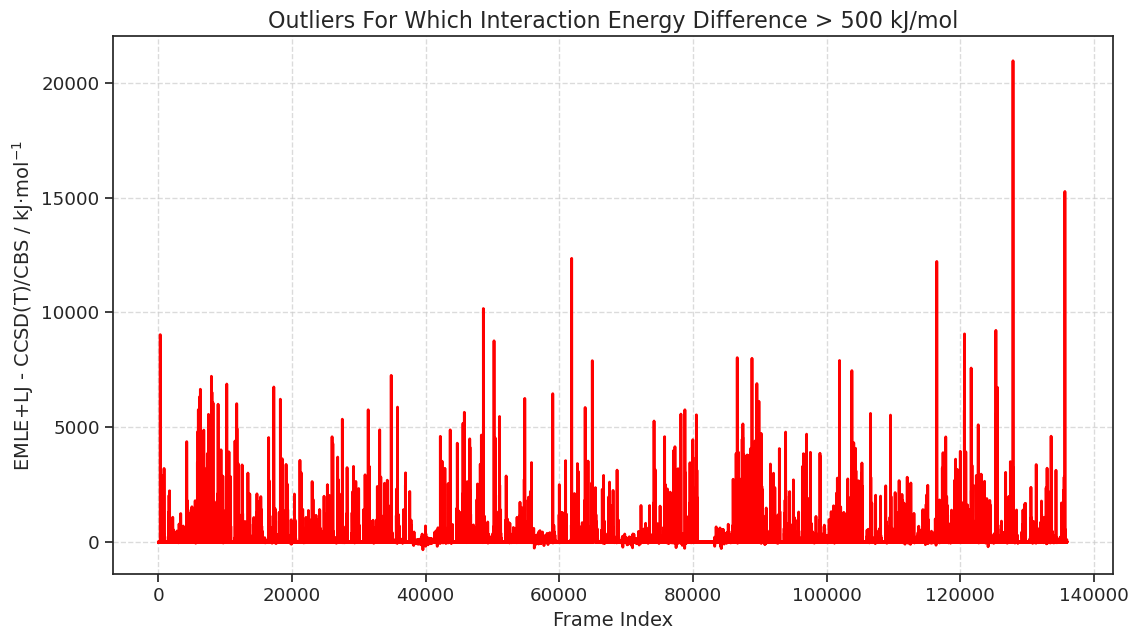

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify outliers
e_lj_initial = e_lj_initial
diff = e_int_predicted + e_lj_initial - e_int_list
x = np.arange(0, len(e_lj_initial))
outliers = x[diff > 600000]
out_list = []

offset = 0
seen = []
for out in outliers:
    for k, v in dataset.items():
        if out > v["frames"][0] and out < v["frames"][-1]:
            if v["name"][0] + "_" + v["name"][1] in seen:
                continue
            else:
                seen.append(v["name"][0] + "_" + v["name"][1])
                offset += 1000
            print(k, v["name"][0] + "_" + v["name"][1], out)
            out_list.append([out, 1000 + offset, v["name"][0] + "_" + v["name"][1]])

# Set the Seaborn style for a clean look
sns.set(style="ticks", palette="muted", font_scale=1.2)

# Create a figure and axis
plt.figure(figsize=(12, 7))

# Plot the energy values as a line plot
#plt.plot(e_int_predicted + e_lj_initial, label='Initial', color='green', linewidth=2)
plt.plot(diff, label='Target', color='red', linewidth=2)

# Highlight the outliers with scatter points
outlier_x = [o[0] for o in out_list]
outlier_y = [o[1] for o in out_list]
plt.scatter(outlier_x, outlier_y, color='blue', marker='o', s=0.1, label='Outliers', zorder=5)

# Add labels and title
plt.xlabel('Frame Index', fontsize=14)
plt.ylabel('EMLE+LJ - CCSD(T)/CBS / kJ·mol$^{-1}$', fontsize=14)
plt.title('Outliers For Which Interaction Energy Difference > 500 kJ/mol', fontsize=16)

# Add text annotations with a bounding box for visibility
for out in out_list:
    plt.text(out[0], out[1], f'{out[2]:s}', fontsize=10, color='black', 
             ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend to the plot
#plt.legend(loc='best', fontsize=12)

# Show the plot with adjusted layout
plt.tight_layout(pad=2.0)
plt.show()


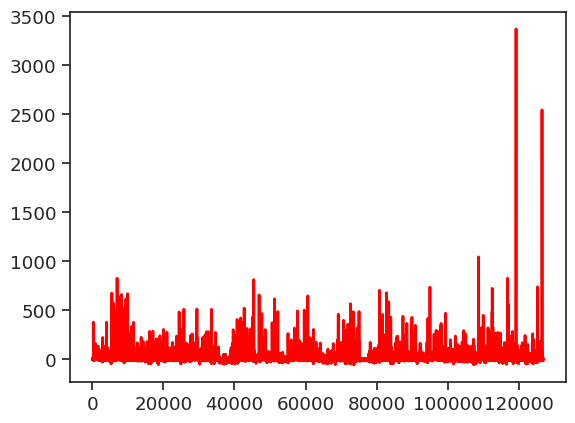

In [14]:
plt.plot(diff[e_int.detach().cpu().numpy() < 50], label='Target', color='red', linewidth=2)

In [15]:
"""
# Define the frame variable
frame = 25  # Select the desired frame

# Assume all the variables are tensors or numpy arrays.
variables = {
    "Distances": lj_potential._distances[frame].detach().cpu().numpy(),
    "Sigma IJ": lj_potential._sigma_ij[frame].detach().cpu().numpy(),
    "Epsilon IJ": lj_potential._epsilon_ij[frame].detach().cpu().numpy(),
    "Inv R": lj_potential._inv_r[frame].detach().cpu().numpy(),
    "Inv R6": lj_potential._inv_r6[frame].detach().cpu().numpy(),
    "Inv R12": lj_potential._inv_r12[frame].detach().cpu().numpy(),
}

# Set up the figure and axes
num_vars = len(variables)
fig, axes = plt.subplots(num_vars, 1, figsize=(4, 20), constrained_layout=True)

# Plot each variable
for ax, (name, data) in zip(axes, variables.items()):
    im = ax.imshow(data, aspect='auto')
    ax.set_title(f"{name} (Frame {frame})")
    fig.colorbar(im, ax=ax)
    ax.set_ylim(6, 11)
    ax.set_xlim(0, 5)

plt.show()
"""

'\n# Define the frame variable\nframe = 25  # Select the desired frame\n\n# Assume all the variables are tensors or numpy arrays.\nvariables = {\n    "Distances": lj_potential._distances[frame].detach().cpu().numpy(),\n    "Sigma IJ": lj_potential._sigma_ij[frame].detach().cpu().numpy(),\n    "Epsilon IJ": lj_potential._epsilon_ij[frame].detach().cpu().numpy(),\n    "Inv R": lj_potential._inv_r[frame].detach().cpu().numpy(),\n    "Inv R6": lj_potential._inv_r6[frame].detach().cpu().numpy(),\n    "Inv R12": lj_potential._inv_r12[frame].detach().cpu().numpy(),\n}\n\n# Set up the figure and axes\nnum_vars = len(variables)\nfig, axes = plt.subplots(num_vars, 1, figsize=(4, 20), constrained_layout=True)\n\n# Plot each variable\nfor ax, (name, data) in zip(axes, variables.items()):\n    im = ax.imshow(data, aspect=\'auto\')\n    ax.set_title(f"{name} (Frame {frame})")\n    fig.colorbar(im, ax=ax)\n    ax.set_ylim(6, 11)\n    ax.set_xlim(0, 5)\n\nplt.show()\n'

In [16]:

torch.autograd.detect_anomaly(True)
from emle_bespoke.bespoke import BespokeModelTrainer as _BespokeModelTrainer

# Fit the Lennard-Jones potential
emle_bespoke = _BespokeModelTrainer(device=device, dtype=dtype)

emle_bespoke.fit_lj(
    lj_potential=lj_potential,
    xyz_qm=xyz_qm,
    xyz_mm=xyz_mm,
    xyz=xyz,
    atomic_numbers=atomic_numbers,
    charges_mm=charges_mm,
    e_int_target=e_int,
    solute_mask=solute_mask,
    solvent_mask=solvent_mask,
    lr=0.001,
    epochs=1000,
)

/tmp/ipykernel_1555634/4147099227.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly(True)
2024-12-18 20:29:53.848 | INFO     | emle_bespoke.bespoke:fit_lj:537 - 
2024-12-18 20:29:53.848 | INFO     | emle_bespoke.bespoke:fit_lj:537 - ╔════════════════════════════════════════════════════════════╗
2024-12-18 20:29:53.848 | INFO     | emle_bespoke.bespoke:fit_lj:537 - ║            Starting fitting of LJ parameters...            ║
2024-12-18 20:29:53.849 | INFO     | emle_bespoke.bespoke:fit_lj:537 - ╚════════════════════════════════════════════════════════════╝
2024-12-18 20:29:53.849 | INFO     | emle_bespoke.bespoke:fit_lj:537 - 


/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:550: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atomic_numbers = _torch.tensor(atomic_numbers)
/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:551: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charges_mm = _torch.tensor(charges_mm)
/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_qm = _torch.tensor(xyz_qm)
/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:553: UserWarning: 

Epoch 1: Loss = 7.773049453948693, RMSE = 235.69286660736068


2024-12-18 20:30:22.874 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 2: Loss =   7.6059    RMSE = 234.4376    Max Error =20773.4191


Epoch 2: Loss = 7.605889270624319, RMSE = 234.4375714194815
Epoch 3: Loss = 7.451220123092808, RMSE = 225.46949365061337
Epoch 4: Loss = 7.304947065656225, RMSE = 220.50475800188877
Epoch 5: Loss = 7.168209946371194, RMSE = 216.77208030846538
Epoch 6: Loss = 7.042277619352199, RMSE = 212.23010029552486
Epoch 7: Loss = 6.924716092672706, RMSE = 206.08882551299308
Epoch 8: Loss = 6.816091077672898, RMSE = 199.27114160030362
Epoch 9: Loss = 6.717115385866895, RMSE = 192.53592310267382


2024-12-18 20:30:29.368 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 10: Loss =   6.6270    RMSE = 186.4401    Max Error =16032.0375


Epoch 10: Loss = 6.627015081121288, RMSE = 186.4400850650443
Epoch 11: Loss = 6.544850291252886, RMSE = 181.13905160537226
Epoch 12: Loss = 6.470429388119323, RMSE = 176.3513333459542
Epoch 13: Loss = 6.403398779401269, RMSE = 171.64688335344462
Epoch 14: Loss = 6.342857555179825, RMSE = 166.77140558960863
Epoch 15: Loss = 6.288029493496731, RMSE = 161.75214563581216
Epoch 16: Loss = 6.23851807721794, RMSE = 156.75495768146757
Epoch 17: Loss = 6.194022144569382, RMSE = 151.99050685505483
Epoch 18: Loss = 6.154055016498058, RMSE = 147.6777437209186
Epoch 19: Loss = 6.117990351585778, RMSE = 143.9619485060225


2024-12-18 20:30:37.528 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 20: Loss =   6.0854    RMSE = 140.8253    Max Error =10998.5396


Epoch 20: Loss = 6.085375405107119, RMSE = 140.82527578275304
Epoch 21: Loss = 6.05595643206506, RMSE = 138.1061851735195
Epoch 22: Loss = 6.029398523023092, RMSE = 135.6042881299699
Epoch 23: Loss = 6.0052642969484795, RMSE = 133.18644629072497
Epoch 24: Loss = 5.983256061086732, RMSE = 130.83563661976325
Epoch 25: Loss = 5.963241078321791, RMSE = 128.6318674123648
Epoch 26: Loss = 5.945043472877531, RMSE = 126.69717219060144
Epoch 27: Loss = 5.928387267422514, RMSE = 125.11875759768981
Epoch 28: Loss = 5.913064704208347, RMSE = 123.8844399756844
Epoch 29: Loss = 5.898984246188542, RMSE = 122.88464835703442


2024-12-18 20:30:45.688 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 30: Loss =   5.8860    RMSE = 121.9756    Max Error =9765.4228


Epoch 30: Loss = 5.886027238834357, RMSE = 121.97559158454055
Epoch 31: Loss = 5.874016726423281, RMSE = 121.05759408304777
Epoch 32: Loss = 5.86283830867095, RMSE = 120.12126256833197
Epoch 33: Loss = 5.852456317332095, RMSE = 119.23939273904448
Epoch 34: Loss = 5.842803786508343, RMSE = 118.51774227373564
Epoch 35: Loss = 5.833768386126413, RMSE = 118.02684183122062
Epoch 36: Loss = 5.825287669346219, RMSE = 117.75435334383259
Epoch 37: Loss = 5.817347678492087, RMSE = 117.61415819345255
Epoch 38: Loss = 5.80990163202489, RMSE = 117.50169465783075
Epoch 39: Loss = 5.802886177807843, RMSE = 117.35638660803704


2024-12-18 20:30:53.848 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 40: Loss =   5.7963    RMSE = 117.1909    Max Error =11649.7655


Epoch 40: Loss = 5.796284063851054, RMSE = 117.19089631896958
Epoch 41: Loss = 5.790091606971307, RMSE = 117.07096064391828
Epoch 42: Loss = 5.7842679805572885, RMSE = 117.06226946325042
Epoch 43: Loss = 5.778772166334997, RMSE = 117.17958401233662
Epoch 44: Loss = 5.773595827099019, RMSE = 117.37404870748708
Epoch 45: Loss = 5.768723452064046, RMSE = 117.56637632679696
Epoch 46: Loss = 5.764117108509958, RMSE = 117.70051353257173
Epoch 47: Loss = 5.759754635601555, RMSE = 117.77926288931513
Epoch 48: Loss = 5.75562844038279, RMSE = 117.85716889891137
Epoch 49: Loss = 5.751712242740821, RMSE = 117.99764746841335


2024-12-18 20:31:02.061 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 50: Loss =   5.7480    RMSE = 118.2253    Max Error =13746.0945


Epoch 50: Loss = 5.7479743725016155, RMSE = 118.22529618890047
Epoch 51: Loss = 5.7444023727616385, RMSE = 118.50825070947589
Epoch 52: Loss = 5.74098362543019, RMSE = 118.78232026901095
Epoch 53: Loss = 5.737693835482821, RMSE = 118.99691559347008
Epoch 54: Loss = 5.734518490271201, RMSE = 119.14791915689108
Epoch 55: Loss = 5.731452158797347, RMSE = 119.27348146174165
Epoch 56: Loss = 5.728480176078422, RMSE = 119.41836662960796
Epoch 57: Loss = 5.725588221197014, RMSE = 119.596201545222
Epoch 58: Loss = 5.722773595276157, RMSE = 119.7793276790406
Epoch 59: Loss = 5.720031754451709, RMSE = 119.92276714722948


2024-12-18 20:31:10.276 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 60: Loss =   5.7174    RMSE = 120.0017    Max Error =15376.7326


Epoch 60: Loss = 5.717353389895263, RMSE = 120.00165486707375
Epoch 61: Loss = 5.714736130066363, RMSE = 120.03144014997079
Epoch 62: Loss = 5.712179203135365, RMSE = 120.05494930529552
Epoch 63: Loss = 5.709675935566778, RMSE = 120.1081122956104
Epoch 64: Loss = 5.707222606016469, RMSE = 120.19295693637727
Epoch 65: Loss = 5.704819723464599, RMSE = 120.27921063222516
Epoch 66: Loss = 5.702463840842771, RMSE = 120.33139808747417
Epoch 67: Loss = 5.7001511452399685, RMSE = 120.33784242862902
Epoch 68: Loss = 5.697881408533777, RMSE = 120.31748605892167
Epoch 69: Loss = 5.695652081111361, RMSE = 120.30039378437492


2024-12-18 20:31:18.491 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 70: Loss =   5.6935    RMSE = 120.3005    Max Error =16301.7385


Epoch 70: Loss = 5.693459085949426, RMSE = 120.30051341313593
Epoch 71: Loss = 5.691301676705015, RMSE = 120.30465391054601
Epoch 72: Loss = 5.6891787619822844, RMSE = 120.28615903284067
Epoch 73: Loss = 5.687087348357061, RMSE = 120.22997089410076
Epoch 74: Loss = 5.685026383852063, RMSE = 120.14643922903414
Epoch 75: Loss = 5.682995031074722, RMSE = 120.06210809525751
Epoch 76: Loss = 5.6809908434652945, RMSE = 119.99682061078654
Epoch 77: Loss = 5.679012926573465, RMSE = 119.94814735513579
Epoch 78: Loss = 5.677061321992647, RMSE = 119.89636453367011
Epoch 79: Loss = 5.675134778169183, RMSE = 119.82419803163612


2024-12-18 20:31:26.704 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 80: Loss =   5.6732    RMSE = 119.7328    Max Error =16394.5412


Epoch 80: Loss = 5.67323264844538, RMSE = 119.7327587229723
Epoch 81: Loss = 5.671354880837089, RMSE = 119.63957222989069
Epoch 82: Loss = 5.6695003577868475, RMSE = 119.56186272713755
Epoch 83: Loss = 5.667668432791875, RMSE = 119.50161066618314
Epoch 84: Loss = 5.665859225471581, RMSE = 119.44605557496273
Epoch 85: Loss = 5.664072088371562, RMSE = 119.38202699058917
Epoch 86: Loss = 5.662306469530595, RMSE = 119.30963309121896
Epoch 87: Loss = 5.660562264925072, RMSE = 119.24220949542706
Epoch 88: Loss = 5.658838829584272, RMSE = 119.19329425837014
Epoch 89: Loss = 5.657135784265081, RMSE = 119.16384957079666


2024-12-18 20:31:34.922 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 90: Loss =   5.6555    RMSE = 119.1420    Max Error =16124.4538


Epoch 90: Loss = 5.655453310816075, RMSE = 119.14195678120257
Epoch 91: Loss = 5.653791215128151, RMSE = 119.11455357833083
Epoch 92: Loss = 5.65214937351026, RMSE = 119.07925237003154
Epoch 93: Loss = 5.650527928497384, RMSE = 119.04489673200452
Epoch 94: Loss = 5.648926709842428, RMSE = 119.02124643440193
Epoch 95: Loss = 5.647345720846899, RMSE = 119.00887256602772
Epoch 96: Loss = 5.6457852275856615, RMSE = 118.9993231691963
Epoch 97: Loss = 5.644245224139408, RMSE = 118.98462672797287
Epoch 98: Loss = 5.642725747978231, RMSE = 118.96578518309818
Epoch 99: Loss = 5.6412268968572645, RMSE = 118.951483734317


2024-12-18 20:31:43.140 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 100: Loss =   5.6397    RMSE = 118.9488    Max Error =15916.1821


Epoch 100: Loss = 5.639748558943237, RMSE = 118.94879960726023
Epoch 101: Loss = 5.638290770014631, RMSE = 118.9559096715907
Epoch 102: Loss = 5.636853623226144, RMSE = 118.9642177350109
Epoch 103: Loss = 5.635437006927501, RMSE = 118.9671752816813
Epoch 104: Loss = 5.634040832453227, RMSE = 118.96625216134909
Epoch 105: Loss = 5.6326649411948715, RMSE = 118.96804560693406
Epoch 106: Loss = 5.631309078672273, RMSE = 118.97628288775167
Epoch 107: Loss = 5.629973129004524, RMSE = 118.98771211629501
Epoch 108: Loss = 5.628656946388865, RMSE = 118.99611722845869
Epoch 109: Loss = 5.627360312109709, RMSE = 118.99954964945947


2024-12-18 20:31:51.357 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 110: Loss =   5.6261    RMSE = 119.0025    Max Error =15882.1901


Epoch 110: Loss = 5.626083037793818, RMSE = 119.00250779511197
Epoch 111: Loss = 5.624824849511366, RMSE = 119.01078158443609
Epoch 112: Loss = 5.6235854982271265, RMSE = 119.02504580705525
Epoch 113: Loss = 5.6223648149021646, RMSE = 119.04046748806364
Epoch 114: Loss = 5.621162578989941, RMSE = 119.05244270696718
Epoch 115: Loss = 5.619978571144232, RMSE = 119.06151777737843
Epoch 116: Loss = 5.6188125450785895, RMSE = 119.07179476911526
Epoch 117: Loss = 5.617664245661521, RMSE = 119.08512685394726
Epoch 118: Loss = 5.616533508734909, RMSE = 119.09849324314227
Epoch 119: Loss = 5.615420154091893, RMSE = 119.10786449827211


2024-12-18 20:31:59.575 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 120: Loss =   5.6143    RMSE = 119.1136    Max Error =15999.3321


Epoch 120: Loss = 5.614323975886947, RMSE = 119.11359141397692
Epoch 121: Loss = 5.613244745787705, RMSE = 119.12027142753885
Epoch 122: Loss = 5.612182192067506, RMSE = 119.1311127213396
Epoch 123: Loss = 5.611136093977914, RMSE = 119.14414228445332
Epoch 124: Loss = 5.61010622544443, RMSE = 119.15533355862766
Epoch 125: Loss = 5.609092346748364, RMSE = 119.16433836881636
Epoch 126: Loss = 5.608094212239731, RMSE = 119.17470240162345
Epoch 127: Loss = 5.607111568477473, RMSE = 119.18827374289258
Epoch 128: Loss = 5.606144209057215, RMSE = 119.20231369716961
Epoch 129: Loss = 5.605191911429095, RMSE = 119.21390314427371


2024-12-18 20:32:07.792 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 130: Loss =   5.6043    RMSE = 119.2245    Max Error =16124.4299


Epoch 130: Loss = 5.604254442014189, RMSE = 119.22447643104847
Epoch 131: Loss = 5.603331555865856, RMSE = 119.23677919406545
Epoch 132: Loss = 5.602423064482885, RMSE = 119.24985854658459
Epoch 133: Loss = 5.601528774811166, RMSE = 119.26183877129705
Epoch 134: Loss = 5.600648475650099, RMSE = 119.27505557961425
Epoch 135: Loss = 5.599781940473141, RMSE = 119.29194451430759
Epoch 136: Loss = 5.598928996158501, RMSE = 119.30936212524793
Epoch 137: Loss = 5.598089459455843, RMSE = 119.32487266370657
Epoch 138: Loss = 5.597263129227162, RMSE = 119.34183693333672
Epoch 139: Loss = 5.596449825466487, RMSE = 119.36059619181692


2024-12-18 20:32:16.009 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 140: Loss =   5.5956    RMSE = 119.3778    Max Error =16214.4704


Epoch 140: Loss = 5.59564938949944, RMSE = 119.37784865460945
Epoch 141: Loss = 5.594861637558124, RMSE = 119.3962006488417
Epoch 142: Loss = 5.594086399874896, RMSE = 119.41575770552662
Epoch 143: Loss = 5.593323534720597, RMSE = 119.43268608033947
Epoch 144: Loss = 5.592572866395643, RMSE = 119.45184788618174
Epoch 145: Loss = 5.591834260533417, RMSE = 119.47119092635165
Epoch 146: Loss = 5.591107576316585, RMSE = 119.49068636804351
Epoch 147: Loss = 5.5903926664835435, RMSE = 119.5130060284818
Epoch 148: Loss = 5.589689436927056, RMSE = 119.53134995023531
Epoch 149: Loss = 5.588997738380052, RMSE = 119.55658880407181


2024-12-18 20:32:24.227 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 150: Loss =   5.5883    RMSE = 119.5679    Max Error =16276.4161


Epoch 150: Loss = 5.588317638359941, RMSE = 119.56785300106121
Epoch 151: Loss = 5.5876495013205405, RMSE = 119.61178893740082
Epoch 152: Loss = 5.586999193971702, RMSE = 119.5726113620387
Epoch 153: Loss = 5.586422112686026, RMSE = 119.77575465084256
Epoch 154: Loss = 5.586384267480806, RMSE = 119.25754651045082
Epoch 155: Loss = 5.587457406871044, RMSE = 120.55252933785628
Epoch 156: Loss = 5.584664362437063, RMSE = 119.16373991203885
Epoch 157: Loss = 5.585720070213923, RMSE = 118.68817719654874
Epoch 158: Loss = 5.584012118955651, RMSE = 120.4064974039697
Epoch 159: Loss = 5.584000739878697, RMSE = 120.62261163236697


2024-12-18 20:32:32.446 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 160: Loss =   5.5827    RMSE = 119.1562    Max Error =16276.4352


Epoch 160: Loss = 5.582709560185764, RMSE = 119.15615313090915
Epoch 161: Loss = 5.582644705541663, RMSE = 118.92791457106954
Epoch 162: Loss = 5.581629303944949, RMSE = 120.2226773338973
Epoch 163: Loss = 5.5814567247833144, RMSE = 120.53727884340272
Epoch 164: Loss = 5.580455086697243, RMSE = 119.55107861057814
Epoch 165: Loss = 5.580299293135159, RMSE = 119.37419536385606
Epoch 166: Loss = 5.579495224926992, RMSE = 120.29682984261147
Epoch 167: Loss = 5.5792240919535425, RMSE = 120.3606646149956
Epoch 168: Loss = 5.578501687909021, RMSE = 119.49032701067875
Epoch 169: Loss = 5.578155211868281, RMSE = 119.50885321378587


2024-12-18 20:32:40.664 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 170: Loss =   5.5777    RMSE = 120.4307    Max Error =16439.1692


Epoch 170: Loss = 5.577662756051223, RMSE = 120.430733678068
Epoch 171: Loss = 5.577138649758596, RMSE = 120.42899685175607
Epoch 172: Loss = 5.5768595028129075, RMSE = 119.67757800512435
Epoch 173: Loss = 5.576115735465816, RMSE = 119.87577450813237
Epoch 174: Loss = 5.576066248254761, RMSE = 120.46674741388816
Epoch 175: Loss = 5.575251287424294, RMSE = 120.14524012891374
Epoch 176: Loss = 5.575276730315162, RMSE = 119.79739784878727
Epoch 177: Loss = 5.574569577025937, RMSE = 120.4174986454792
Epoch 178: Loss = 5.574309736724115, RMSE = 120.51150060821448
Epoch 179: Loss = 5.574008152505602, RMSE = 119.91463646414594


2024-12-18 20:32:48.881 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 180: Loss =   5.5734    RMSE = 120.1770    Max Error =16477.7332


Epoch 180: Loss = 5.573403646796102, RMSE = 120.17702707077183
Epoch 181: Loss = 5.573305680812226, RMSE = 120.57147741073723
Epoch 182: Loss = 5.572802847957507, RMSE = 120.18932907034751
Epoch 183: Loss = 5.572429903343937, RMSE = 120.30281188368176
Epoch 184: Loss = 5.57228626853024, RMSE = 120.71226637059448
Epoch 185: Loss = 5.571808786974931, RMSE = 120.29255305264658
Epoch 186: Loss = 5.571460613967341, RMSE = 120.33906141915877
Epoch 187: Loss = 5.571305786107531, RMSE = 120.6900005146367
Epoch 188: Loss = 5.570958386712107, RMSE = 120.32751542308006
Epoch 189: Loss = 5.570547231551859, RMSE = 120.6307619166112


2024-12-18 20:32:57.097 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 190: Loss =   5.5703    RMSE = 120.6785    Max Error =16578.8149


Epoch 190: Loss = 5.570265437683857, RMSE = 120.67853402538243
Epoch 191: Loss = 5.57008213768872, RMSE = 120.42111737115164
Epoch 192: Loss = 5.569897481858747, RMSE = 120.86286759804831
Epoch 193: Loss = 5.569599840473494, RMSE = 120.41137508297574
Epoch 194: Loss = 5.56929065388539, RMSE = 120.90894477186865
Epoch 195: Loss = 5.5689525090698435, RMSE = 120.57438991430483
Epoch 196: Loss = 5.568654090460051, RMSE = 120.92843362079573
Epoch 197: Loss = 5.56837950509039, RMSE = 120.65649523858217
Epoch 198: Loss = 5.568162876946517, RMSE = 120.98230436355826
Epoch 199: Loss = 5.568054592792599, RMSE = 120.57291408386223


2024-12-18 20:33:05.312 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 200: Loss =   5.5684    RMSE = 121.3282    Max Error =16664.2880


Epoch 200: Loss = 5.5684148704929575, RMSE = 121.32821965093667
Epoch 201: Loss = 5.569448177345139, RMSE = 120.16832665018971
Epoch 202: Loss = 5.571970361976146, RMSE = 122.02523790245552
Epoch 203: Loss = 5.567669809120774, RMSE = 120.14990520125558
Epoch 204: Loss = 5.5676296954086055, RMSE = 120.1628483221841
Epoch 205: Loss = 5.57015088033869, RMSE = 121.96168424815278
Epoch 206: Loss = 5.566352788118312, RMSE = 120.69980976930836
Epoch 207: Loss = 5.568304707167772, RMSE = 120.17009031432295
Epoch 208: Loss = 5.569376231512877, RMSE = 122.0234553244601
Epoch 209: Loss = 5.5658416512638045, RMSE = 121.09546515319364


2024-12-18 20:33:13.530 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 210: Loss =   5.5701    RMSE = 119.7935    Max Error =16620.2585


Epoch 210: Loss = 5.570097670632696, RMSE = 119.7935498423661
Epoch 211: Loss = 5.567269393188041, RMSE = 121.82156125953678
Epoch 212: Loss = 5.567127540064977, RMSE = 121.85601824099658
Epoch 213: Loss = 5.5677997742656915, RMSE = 120.0885185184379
Epoch 214: Loss = 5.564833205798634, RMSE = 120.81401409466353
Epoch 215: Loss = 5.5670257763550275, RMSE = 121.90838319027584
Epoch 216: Loss = 5.5644382527323994, RMSE = 120.99678048746318
Epoch 217: Loss = 5.566601398220844, RMSE = 120.24735107780523
Epoch 218: Loss = 5.5648553979823845, RMSE = 121.61960321555527
Epoch 219: Loss = 5.565173674011111, RMSE = 121.80705418900597


2024-12-18 20:33:21.748 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 220: Loss =   5.5650    RMSE = 120.6045    Max Error =16715.6289


Epoch 220: Loss = 5.564983055780875, RMSE = 120.60447956481623
Epoch 221: Loss = 5.563838305299434, RMSE = 120.96125947751581
Epoch 222: Loss = 5.564823303342717, RMSE = 121.88230032797291
Epoch 223: Loss = 5.563346311936968, RMSE = 121.26598535009988
Epoch 224: Loss = 5.5644814789488315, RMSE = 120.65437124154302
Epoch 225: Loss = 5.563537512850795, RMSE = 121.62749683059481
Epoch 226: Loss = 5.563387181138069, RMSE = 121.61876671206285
Epoch 227: Loss = 5.563734968038786, RMSE = 120.72330012779388
Epoch 228: Loss = 5.562604441759434, RMSE = 121.30327502498527
Epoch 229: Loss = 5.563139534925734, RMSE = 121.76259899935302


2024-12-18 20:33:29.966 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 230: Loss =   5.5626    RMSE = 121.0826    Max Error =16802.8101


Epoch 230: Loss = 5.56259104058097, RMSE = 121.08258155780672
Epoch 231: Loss = 5.562277939292333, RMSE = 121.21402677746798
Epoch 232: Loss = 5.562593851038463, RMSE = 121.82555302579966
Epoch 233: Loss = 5.561915412716183, RMSE = 121.32563835958022
Epoch 234: Loss = 5.5619982329475475, RMSE = 121.19202137023655
Epoch 235: Loss = 5.562099156054887, RMSE = 121.84646576452806
Epoch 236: Loss = 5.561462034127214, RMSE = 121.41548874548879
Epoch 237: Loss = 5.561577689383027, RMSE = 121.24197795850077
Epoch 238: Loss = 5.5617196335695676, RMSE = 121.88752858712643
Epoch 239: Loss = 5.561106702614762, RMSE = 121.37556582622044


2024-12-18 20:33:38.184 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 240: Loss =   5.5610    RMSE = 121.3705    Max Error =16864.3181


Epoch 240: Loss = 5.561008476489685, RMSE = 121.37047022293571
Epoch 241: Loss = 5.561256373410924, RMSE = 121.93267001547909
Epoch 242: Loss = 5.560918787836098, RMSE = 121.36165531833706
Epoch 243: Loss = 5.560513971177475, RMSE = 121.73145884597476
Epoch 244: Loss = 5.560430062841904, RMSE = 121.82029494856893
Epoch 245: Loss = 5.560535364404912, RMSE = 121.46314285889909
Epoch 246: Loss = 5.560591996037764, RMSE = 122.07572544635224
Epoch 247: Loss = 5.560311034139878, RMSE = 121.47492917109383
Epoch 248: Loss = 5.560026555617866, RMSE = 121.94811194158507
Epoch 249: Loss = 5.55976471550658, RMSE = 121.6810430043691


2024-12-18 20:33:46.402 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 250: Loss =   5.5596    RMSE = 121.7913    Max Error =16932.6121


Epoch 250: Loss = 5.559606062938519, RMSE = 121.79130240697692
Epoch 251: Loss = 5.559530741381253, RMSE = 121.93154137508431
Epoch 252: Loss = 5.559541193118429, RMSE = 121.66655218735107
Epoch 253: Loss = 5.559788484720921, RMSE = 122.2136688579737
Epoch 254: Loss = 5.560467267061405, RMSE = 121.37059222323055
Epoch 255: Loss = 5.563448788706486, RMSE = 122.86920289185049
Epoch 256: Loss = 5.565376695388042, RMSE = 120.66330877409821
Epoch 257: Loss = 5.571808497689166, RMSE = 123.43058659116043
Epoch 258: Loss = 5.559375444227635, RMSE = 120.95940903966384
Epoch 259: Loss = 5.567238025176777, RMSE = 120.03851240212516


2024-12-18 20:33:54.620 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 260: Loss =   5.5784    RMSE = 123.8350    Max Error =16997.8223


Epoch 260: Loss = 5.578428578238202, RMSE = 123.83498227232536
Epoch 261: Loss = 5.561287411800477, RMSE = 121.96946833625157
Epoch 262: Loss = 5.588019520616925, RMSE = 118.81141478390632
Epoch 263: Loss = 5.573714560831859, RMSE = 123.12110284198683
Epoch 264: Loss = 5.587338348229893, RMSE = 123.76251046651136
Epoch 265: Loss = 5.560547162035157, RMSE = 120.39136935780083
Epoch 266: Loss = 5.589372424287562, RMSE = 117.88500962153469
Epoch 267: Loss = 5.5598998636004975, RMSE = 121.033393693499
Epoch 268: Loss = 5.57687777940809, RMSE = 123.84246326995783
Epoch 269: Loss = 5.570678434952294, RMSE = 123.24633023505928


2024-12-18 20:34:02.839 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 270: Loss =   5.5608    RMSE = 120.5926    Max Error =16809.3863


Epoch 270: Loss = 5.560824738938767, RMSE = 120.59256320946234
Epoch 271: Loss = 5.574456071219284, RMSE = 119.20811666430068
Epoch 272: Loss = 5.561518371329282, RMSE = 120.99056713380418
Epoch 273: Loss = 5.564910019590433, RMSE = 123.43452835883097
Epoch 274: Loss = 5.568844921041371, RMSE = 123.91276327871594
Epoch 275: Loss = 5.561188234478033, RMSE = 122.20967591704859
Epoch 276: Loss = 5.563489187177236, RMSE = 120.14109569466865
Epoch 277: Loss = 5.565952985430999, RMSE = 119.70405953371883
Epoch 278: Loss = 5.560207320973215, RMSE = 121.0614010046359
Epoch 279: Loss = 5.563197060114406, RMSE = 122.55453261507692


2024-12-18 20:34:11.058 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 280: Loss =   5.5642    RMSE = 122.7246    Max Error =16993.4195


Epoch 280: Loss = 5.564219009402308, RMSE = 122.72462960276194
Epoch 281: Loss = 5.5603942860300695, RMSE = 121.57397182150616
Epoch 282: Loss = 5.561830825584755, RMSE = 120.30574147862104
Epoch 283: Loss = 5.563175221535844, RMSE = 120.185510775165
Epoch 284: Loss = 5.560072887055759, RMSE = 121.33964260077931
Epoch 285: Loss = 5.561199620411963, RMSE = 122.67632628716372
Epoch 286: Loss = 5.562300068162734, RMSE = 123.01619968048476
Epoch 287: Loss = 5.560071390422323, RMSE = 122.1782163238955
Epoch 288: Loss = 5.560476250028182, RMSE = 121.01639456011054
Epoch 289: Loss = 5.561559715206975, RMSE = 120.58791079057515


2024-12-18 20:34:19.276 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 290: Loss =   5.5599    RMSE = 121.1767    Max Error =16975.2834


Epoch 290: Loss = 5.559878169423925, RMSE = 121.1766883376889
Epoch 291: Loss = 5.560058629534792, RMSE = 122.10168311532036
Epoch 292: Loss = 5.560834539535127, RMSE = 122.47132119977142
Epoch 293: Loss = 5.559717132756346, RMSE = 122.01145459325423
Epoch 294: Loss = 5.559719722157693, RMSE = 121.25532132189409
Epoch 295: Loss = 5.560226547503765, RMSE = 120.9898491841004
Epoch 296: Loss = 5.559391085869604, RMSE = 121.47492712061548
Epoch 297: Loss = 5.559505504191219, RMSE = 122.23456590120206
Epoch 298: Loss = 5.55972099437603, RMSE = 122.61049028891829
Epoch 299: Loss = 5.559053316874922, RMSE = 122.38832779364834


2024-12-18 20:34:27.491 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 300: Loss =   5.5592    RMSE = 121.9525    Max Error =17064.3403


Epoch 300: Loss = 5.559249591641504, RMSE = 121.9524781173164
Epoch 301: Loss = 5.559278475661579, RMSE = 121.85649280782766
Epoch 302: Loss = 5.558726854918415, RMSE = 122.19636238445305
Epoch 303: Loss = 5.559010938689826, RMSE = 122.54775234334028
Epoch 304: Loss = 5.558852447607904, RMSE = 122.51751619115625
Epoch 305: Loss = 5.558474834788842, RMSE = 122.16837710197285
Epoch 306: Loss = 5.558729441275791, RMSE = 121.93139013578363
Epoch 307: Loss = 5.558423531023121, RMSE = 122.10659412555074
Epoch 308: Loss = 5.558293359968571, RMSE = 122.47907844354717
Epoch 309: Loss = 5.558391928197031, RMSE = 122.61022302836382


2024-12-18 20:34:35.707 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 310: Loss =   5.5581    RMSE = 122.3838    Max Error =17054.2034


Epoch 310: Loss = 5.5580702289854305, RMSE = 122.38383617414398
Epoch 311: Loss = 5.5581150366573775, RMSE = 122.12409036656626
Epoch 312: Loss = 5.557999851051363, RMSE = 122.19395923238976
Epoch 313: Loss = 5.557817932663909, RMSE = 122.51295498539743
Epoch 314: Loss = 5.557873413886098, RMSE = 122.66859887855617
Epoch 315: Loss = 5.557629320347488, RMSE = 122.47632819028534
Epoch 316: Loss = 5.557638269980932, RMSE = 122.20518984924757
Epoch 317: Loss = 5.557526384194317, RMSE = 122.21426102864494
Epoch 318: Loss = 5.557391628922761, RMSE = 122.44841823536579
Epoch 319: Loss = 5.557387151679078, RMSE = 122.54507358067784


2024-12-18 20:34:43.923 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 320: Loss =   5.5572    RMSE = 122.3770    Max Error =17130.9411


Epoch 320: Loss = 5.557208289654963, RMSE = 122.3769788553114
Epoch 321: Loss = 5.557207271750014, RMSE = 122.21625321201704
Epoch 322: Loss = 5.557053174919508, RMSE = 122.3173694138163
Epoch 323: Loss = 5.557017807806589, RMSE = 122.52074372479524
Epoch 324: Loss = 5.556911424540225, RMSE = 122.54055867492733
Epoch 325: Loss = 5.556829569908598, RMSE = 122.4181606771876
Epoch 326: Loss = 5.556766757612458, RMSE = 122.42793789789764
Epoch 327: Loss = 5.556658197925175, RMSE = 122.58844200434841
Epoch 328: Loss = 5.556610644669283, RMSE = 122.63468457329438
Epoch 329: Loss = 5.556499809889973, RMSE = 122.51340549544305


2024-12-18 20:34:52.141 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 330: Loss =   5.5565    RMSE = 122.4835    Max Error =17182.3150


Epoch 330: Loss = 5.556456042090132, RMSE = 122.4834839435228
Epoch 331: Loss = 5.556345741030908, RMSE = 122.64587210001771
Epoch 332: Loss = 5.55630296202655, RMSE = 122.74412615152102
Epoch 333: Loss = 5.556198020942649, RMSE = 122.65396105761289
Epoch 334: Loss = 5.556150644199321, RMSE = 122.60504738738076
Epoch 335: Loss = 5.55605611688784, RMSE = 122.72608674855185
Epoch 336: Loss = 5.556001361197864, RMSE = 122.79908171840862
Epoch 337: Loss = 5.555916339509217, RMSE = 122.73416239702857
Epoch 338: Loss = 5.555856048922448, RMSE = 122.74131745046171
Epoch 339: Loss = 5.555781807365937, RMSE = 122.85590083607556


2024-12-18 20:35:00.358 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 340: Loss =   5.5557    RMSE = 122.8571    Max Error =17226.5546


Epoch 340: Loss = 5.555711518842174, RMSE = 122.85711045678157
Epoch 341: Loss = 5.555651284882402, RMSE = 122.77847753508753
Epoch 342: Loss = 5.555571663077938, RMSE = 122.83430005656203
Epoch 343: Loss = 5.555519126586855, RMSE = 122.9172786492818
Epoch 344: Loss = 5.555441283780316, RMSE = 122.86275373673351
Epoch 345: Loss = 5.555384586976023, RMSE = 122.84061723488877
Epoch 346: Loss = 5.555318808196547, RMSE = 122.9305605837964
Epoch 347: Loss = 5.5552508766062605, RMSE = 122.93293331263713
Epoch 348: Loss = 5.555196811223497, RMSE = 122.8966213548819
Epoch 349: Loss = 5.555127326707692, RMSE = 122.97454399496812


2024-12-18 20:35:08.577 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 350: Loss =   5.5551    RMSE = 122.9944    Max Error =17273.4207


Epoch 350: Loss = 5.555068619303387, RMSE = 122.99436850341532
Epoch 351: Loss = 5.55501195281975, RMSE = 122.93615307499105
Epoch 352: Loss = 5.554945931879722, RMSE = 122.99090410422318
Epoch 353: Loss = 5.554890172538507, RMSE = 123.02628086262318
Epoch 354: Loss = 5.554834334735034, RMSE = 122.98577586711674
Epoch 355: Loss = 5.554771777901694, RMSE = 123.04156991368761
Epoch 356: Loss = 5.554716205604523, RMSE = 123.05913602103101
Epoch 357: Loss = 5.554663455666284, RMSE = 123.0212554573786
Epoch 358: Loss = 5.55460501068647, RMSE = 123.08752226461655
Epoch 359: Loss = 5.554548067847281, RMSE = 123.08891175750927


2024-12-18 20:35:16.795 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 360: Loss =   5.5545    RMSE = 123.0825    Max Error =17316.6585


Epoch 360: Loss = 5.554496462495203, RMSE = 123.08251229955523
Epoch 361: Loss = 5.5544444431294915, RMSE = 123.14661080424686
Epoch 362: Loss = 5.554389585843611, RMSE = 123.11412302131964
Epoch 363: Loss = 5.554335040020994, RMSE = 123.15668251443337
Epoch 364: Loss = 5.554283716650054, RMSE = 123.17941658512909
Epoch 365: Loss = 5.554234626285146, RMSE = 123.16163941457982
Epoch 366: Loss = 5.554185536440004, RMSE = 123.21982152515955
Epoch 367: Loss = 5.554135904214508, RMSE = 123.17513385907445
Epoch 368: Loss = 5.554086011192854, RMSE = 123.24314825999339
Epoch 369: Loss = 5.554036600126518, RMSE = 123.20890554571089


2024-12-18 20:35:25.012 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 370: Loss =   5.5540    RMSE = 123.2729    Max Error =17359.8266


Epoch 370: Loss = 5.553988214602145, RMSE = 123.27291989239279
Epoch 371: Loss = 5.553941162644912, RMSE = 123.23562365230464
Epoch 372: Loss = 5.553896591150984, RMSE = 123.30800670403976
Epoch 373: Loss = 5.553857304295229, RMSE = 123.24040085500471
Epoch 374: Loss = 5.553834532484253, RMSE = 123.38291319678045
Epoch 375: Loss = 5.553862972305823, RMSE = 123.1828333035578
Epoch 376: Loss = 5.5541131401768595, RMSE = 123.58925756890507
Epoch 377: Loss = 5.555085436192574, RMSE = 122.86349923612994
Epoch 378: Loss = 5.560412632842307, RMSE = 124.43440452698712
Epoch 379: Loss = 5.570795740055158, RMSE = 121.69518970490564


2024-12-18 20:35:33.232 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 380: Loss =   5.6327    RMSE = 127.2906    Max Error =17419.1009


Epoch 380: Loss = 5.632722078556875, RMSE = 127.29063785969943
Epoch 381: Loss = 5.5572965188743675, RMSE = 122.334750167341
Epoch 382: Loss = 5.905506569544984, RMSE = 116.9333865869949
Epoch 383: Loss = 5.859222279772585, RMSE = 130.7066115357708
Epoch 384: Loss = 6.337763883238306, RMSE = 136.28204192770417
Epoch 385: Loss = 6.530809060684614, RMSE = 134.8398133968258
Epoch 386: Loss = 6.500133921593542, RMSE = 129.3239353968777
Epoch 387: Loss = 6.376280091004301, RMSE = 121.80831505216591
Epoch 388: Loss = 6.2554748176343695, RMSE = 113.9645690668769
Epoch 389: Loss = 6.173510864049071, RMSE = 107.133986718588


2024-12-18 20:35:41.451 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 390: Loss =   6.1213    RMSE = 102.2095    Max Error =12413.3834


Epoch 390: Loss = 6.1213304475056916, RMSE = 102.20950439570925
Epoch 391: Loss = 6.077172928344089, RMSE = 99.55206327128245
Epoch 392: Loss = 6.029759874659951, RMSE = 99.08955638979954
Epoch 393: Loss = 5.981280172276355, RMSE = 100.49320980198259
Epoch 394: Loss = 5.935635126179837, RMSE = 103.2824882761308
Epoch 395: Loss = 5.891809861396194, RMSE = 106.87855457586863
Epoch 396: Loss = 5.85231009831881, RMSE = 110.70526621423436
Epoch 397: Loss = 5.822064890958887, RMSE = 114.2825178786005
Epoch 398: Loss = 5.801938526918786, RMSE = 117.2078872731826
Epoch 399: Loss = 5.787869946400254, RMSE = 119.18217732170027


2024-12-18 20:35:49.668 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 400: Loss =   5.7746    RMSE = 120.1159    Max Error =14813.7064


Epoch 400: Loss = 5.774611973509239, RMSE = 120.11593968679507
Epoch 401: Loss = 5.7584984704239774, RMSE = 120.14808139590833
Epoch 402: Loss = 5.737943780573637, RMSE = 119.54511003069925
Epoch 403: Loss = 5.714546756064612, RMSE = 118.58210427278713
Epoch 404: Loss = 5.69201974110829, RMSE = 117.48092069680568
Epoch 405: Loss = 5.673203113391086, RMSE = 116.39305118646516
Epoch 406: Loss = 5.658949533335356, RMSE = 115.40318046791934
Epoch 407: Loss = 5.648780560357423, RMSE = 114.54422782633236
Epoch 408: Loss = 5.64189312683656, RMSE = 113.81491229230106
Epoch 409: Loss = 5.637739961641427, RMSE = 113.19349556900286


2024-12-18 20:35:57.883 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 410: Loss =   5.6360    RMSE = 112.6467    Max Error =15647.5666


Epoch 410: Loss = 5.636038615140855, RMSE = 112.64670068465824
Epoch 411: Loss = 5.636436911034834, RMSE = 112.13633722188064
Epoch 412: Loss = 5.638178976574808, RMSE = 111.62608007595557
Epoch 413: Loss = 5.640050891012582, RMSE = 111.08880823650651
Epoch 414: Loss = 5.640710072446388, RMSE = 110.51347458203911
Epoch 415: Loss = 5.639239866052279, RMSE = 109.91019184464793
Epoch 416: Loss = 5.635557843679722, RMSE = 109.31177883643147
Epoch 417: Loss = 5.630392552701033, RMSE = 108.7697280508748
Epoch 418: Loss = 5.624886698939948, RMSE = 108.34430251134928
Epoch 419: Loss = 5.620117425760628, RMSE = 108.0914920791867


2024-12-18 20:36:06.096 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 420: Loss =   5.6168    RMSE = 108.0510    Max Error =15683.5927


Epoch 420: Loss = 5.616774530270636, RMSE = 108.05104589860476
Epoch 421: Loss = 5.615061885191465, RMSE = 108.23893049974083
Epoch 422: Loss = 5.614766037264324, RMSE = 108.64561992242747
Epoch 423: Loss = 5.615408361898221, RMSE = 109.23979809149318
Epoch 424: Loss = 5.616417175938035, RMSE = 109.97580265180814
Epoch 425: Loss = 5.617279385649623, RMSE = 110.8025704845432
Epoch 426: Loss = 5.617645362116451, RMSE = 111.67190522959413
Epoch 427: Loss = 5.617371850074779, RMSE = 112.54440069946013
Epoch 428: Loss = 5.616502176672705, RMSE = 113.39212977414584
Epoch 429: Loss = 5.615201153970901, RMSE = 114.19808392729048


2024-12-18 20:36:14.309 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 430: Loss =   5.6137    RMSE = 114.9531    Max Error =14979.2941


Epoch 430: Loss = 5.613676840404255, RMSE = 114.95314019036266
Epoch 431: Loss = 5.612122018711374, RMSE = 115.65184486945765
Epoch 432: Loss = 5.610690710667876, RMSE = 116.28841720896877
Epoch 433: Loss = 5.6094997704857406, RMSE = 116.85410322948754
Epoch 434: Loss = 5.60863209715888, RMSE = 117.3364815353511
Epoch 435: Loss = 5.608126548884994, RMSE = 117.72073257775277
Epoch 436: Loss = 5.607960095099687, RMSE = 117.99239786081716
Epoch 437: Loss = 5.608040742859897, RMSE = 118.1408485625587
Epoch 438: Loss = 5.608225580491452, RMSE = 118.16255092849198
Epoch 439: Loss = 5.608362017828174, RMSE = 118.06325369345596


2024-12-18 20:36:22.527 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 440: Loss =   5.6083    RMSE = 117.8585    Max Error =14204.7882


Epoch 440: Loss = 5.608334667192914, RMSE = 117.85845236669641
Epoch 441: Loss = 5.60809615979588, RMSE = 117.57190263898481
Epoch 442: Loss = 5.607669664723192, RMSE = 117.23246632221073
Epoch 443: Loss = 5.607126423313718, RMSE = 116.87000723071326
Epoch 444: Loss = 5.606552627835694, RMSE = 116.51126096238286
Epoch 445: Loss = 5.606021124213248, RMSE = 116.17654043199555
Epoch 446: Loss = 5.6055768384448434, RMSE = 115.87787770709731
Epoch 447: Loss = 5.605236186639643, RMSE = 115.61885480798664
Epoch 448: Loss = 5.604994823830766, RMSE = 115.39603158036229
Epoch 449: Loss = 5.604836973621927, RMSE = 115.20158589871558


2024-12-18 20:36:30.745 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 450: Loss =   5.6047    RMSE = 115.0266    Max Error =14895.2764


Epoch 450: Loss = 5.604742349343238, RMSE = 115.02656782945678
Epoch 451: Loss = 5.604690290454774, RMSE = 114.86406416125332
Epoch 452: Loss = 5.6046623700844505, RMSE = 114.71160126057174
Epoch 453: Loss = 5.604644069133815, RMSE = 114.57228917068332
Epoch 454: Loss = 5.604625081059957, RMSE = 114.45449695592833
Epoch 455: Loss = 5.60459807980621, RMSE = 114.3701812529021
Epoch 456: Loss = 5.604557036966708, RMSE = 114.33228302853882
Epoch 457: Loss = 5.604496796525349, RMSE = 114.35178979951206
Epoch 458: Loss = 5.604414633431829, RMSE = 114.43509678112949
Epoch 459: Loss = 5.604312654246692, RMSE = 114.58220009695812


2024-12-18 20:36:38.964 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 460: Loss =   5.6042    RMSE = 114.7861    Max Error =15231.1633


Epoch 460: Loss = 5.604198811833777, RMSE = 114.78606048385227
Epoch 461: Loss = 5.604085030287467, RMSE = 115.03323891488733
Epoch 462: Loss = 5.603982970228145, RMSE = 115.30566991995208
Epoch 463: Loss = 5.603899742694779, RMSE = 115.5832353669868
Epoch 464: Loss = 5.603836039629811, RMSE = 115.8466569000113
Epoch 465: Loss = 5.603787563435467, RMSE = 116.0801654773255
Epoch 466: Loss = 5.603748486446028, RMSE = 116.27345315354086
Epoch 467: Loss = 5.603714528026982, RMSE = 116.42256714777383
Epoch 468: Loss = 5.60368386434582, RMSE = 116.529638837851
Epoch 469: Loss = 5.603655875957609, RMSE = 116.60159145389495


2024-12-18 20:36:47.181 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 470: Loss =   5.6036    RMSE = 116.6482    Max Error =15142.9658


Epoch 470: Loss = 5.6036292636722616, RMSE = 116.64817291943926
Epoch 471: Loss = 5.603601247188937, RMSE = 116.67976567167128
Epoch 472: Loss = 5.603568462275423, RMSE = 116.70541863855495
Epoch 473: Loss = 5.603528785232012, RMSE = 116.7314462374156
Epoch 474: Loss = 5.603482683297037, RMSE = 116.76078332940853
Epoch 475: Loss = 5.603433142916507, RMSE = 116.79311507122726
Epoch 476: Loss = 5.603384271287311, RMSE = 116.82565060771815
Epoch 477: Loss = 5.603339490383157, RMSE = 116.85430245690355
Epoch 478: Loss = 5.6033003414392315, RMSE = 116.87498204045193
Epoch 479: Loss = 5.6032663735519295, RMSE = 116.88473024353537


2024-12-18 20:36:55.401 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 480: Loss =   5.6032    RMSE = 116.8825    Max Error =15100.3348


Epoch 480: Loss = 5.603235891246706, RMSE = 116.8824652448186
Epoch 481: Loss = 5.603206954279539, RMSE = 116.86923304394912
Epoch 482: Loss = 5.603178097254043, RMSE = 116.84796492275369
Epoch 483: Loss = 5.603148570841186, RMSE = 116.8228523551575
Epoch 484: Loss = 5.603118209505838, RMSE = 116.79851952206013
Epoch 485: Loss = 5.603087149302799, RMSE = 116.77919371429259
Epoch 486: Loss = 5.603055582643559, RMSE = 116.76804588475417
Epoch 487: Loss = 5.603023644889968, RMSE = 116.76681093778409
Epoch 488: Loss = 5.602991440764059, RMSE = 116.77572007294793
Epoch 489: Loss = 5.602959147575737, RMSE = 116.79370592131917


2024-12-18 20:37:03.621 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 490: Loss =   5.6029    RMSE = 116.8188    Max Error =15146.6373


Epoch 490: Loss = 5.602927088463908, RMSE = 116.81879088405023
Epoch 491: Loss = 5.602895683991473, RMSE = 116.8485480403354
Epoch 492: Loss = 5.602865277514371, RMSE = 116.88053209109904
Epoch 493: Loss = 5.602835940174272, RMSE = 116.9126079084577
Epoch 494: Loss = 5.602807404628923, RMSE = 116.94314485049135
Epoch 495: Loss = 5.602779199781228, RMSE = 116.97108359188383
Epoch 496: Loss = 5.602750909904108, RMSE = 116.99590876577788
Epoch 497: Loss = 5.602722382612262, RMSE = 117.01757014882475
Epoch 498: Loss = 5.602693749597105, RMSE = 117.03638837953858
Epoch 499: Loss = 5.60266527022504, RMSE = 117.0529643198308


2024-12-18 20:37:11.839 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 500: Loss =   5.6026    RMSE = 117.0681    Max Error =15189.0284


Epoch 500: Loss = 5.602637135039773, RMSE = 117.06809279035198
Epoch 501: Loss = 5.602609371359427, RMSE = 117.08266952952836
Epoch 502: Loss = 5.60258188847429, RMSE = 117.09757940709962
Epoch 503: Loss = 5.602554588601582, RMSE = 117.11356388876911
Epoch 504: Loss = 5.602527442257139, RMSE = 117.13108175971047
Epoch 505: Loss = 5.6025004848487185, RMSE = 117.15019191805736
Epoch 506: Loss = 5.602473765135264, RMSE = 117.17049364890576
Epoch 507: Loss = 5.602447301122691, RMSE = 117.19115401166435
Epoch 508: Loss = 5.602421070755605, RMSE = 117.21103396886815
Epoch 509: Loss = 5.602395026817309, RMSE = 117.2288991785157


2024-12-18 20:37:20.057 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 510: Loss =   5.6024    RMSE = 117.2437    Max Error =15243.8015


Epoch 510: Loss = 5.602369114851291, RMSE = 117.24367555694758
Epoch 511: Loss = 5.602343286590478, RMSE = 117.25469216607164
Epoch 512: Loss = 5.602317512195258, RMSE = 117.26185116012186
Epoch 513: Loss = 5.602291789408106, RMSE = 117.2656787321071
Epoch 514: Loss = 5.6022661400145, RMSE = 117.2672392519737
Epoch 515: Loss = 5.602240590715156, RMSE = 117.26792948960117
Epoch 516: Loss = 5.6022151520481485, RMSE = 117.2692010333213
Epoch 517: Loss = 5.602189814500747, RMSE = 117.27227764343141
Epoch 518: Loss = 5.602164565575235, RMSE = 117.27793493498976
Epoch 519: Loss = 5.602139410360116, RMSE = 117.28639241155307


2024-12-18 20:37:28.272 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 520: Loss =   5.6021    RMSE = 117.2973    Max Error =15274.4544


Epoch 520: Loss = 5.602114374297906, RMSE = 117.29733762728935
Epoch 521: Loss = 5.6020894848453935, RMSE = 117.31006783161027
Epoch 522: Loss = 5.602064749373385, RMSE = 117.32370546778107
Epoch 523: Loss = 5.602040148893152, RMSE = 117.33742812759485
Epoch 524: Loss = 5.6020156507678225, RMSE = 117.35065474389846
Epoch 525: Loss = 5.601991227085362, RMSE = 117.3631466310499
Epoch 526: Loss = 5.601966864387498, RMSE = 117.37500864270332
Epoch 527: Loss = 5.601942562009241, RMSE = 117.38660380119649
Epoch 528: Loss = 5.601918325869342, RMSE = 117.39841600368239
Epoch 529: Loss = 5.601894163958059, RMSE = 117.41090431458836


2024-12-18 20:37:36.485 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 530: Loss =   5.6019    RMSE = 117.4244    Max Error =15300.4984


Epoch 530: Loss = 5.6018700839914715, RMSE = 117.42438770897715
Epoch 531: Loss = 5.601846091398083, RMSE = 117.43898406665653
Epoch 532: Loss = 5.601822188051239, RMSE = 117.45460776911116
Epoch 533: Loss = 5.601798373421701, RMSE = 117.47101309192755
Epoch 534: Loss = 5.601774647293908, RMSE = 117.48786074927472
Epoch 535: Loss = 5.601751010677449, RMSE = 117.50478433387266
Epoch 536: Loss = 5.60172746336002, RMSE = 117.52144048819753
Epoch 537: Loss = 5.601704000894537, RMSE = 117.53753743908545
Epoch 538: Loss = 5.601680615030258, RMSE = 117.55284627417922
Epoch 539: Loss = 5.601657297862844, RMSE = 117.56720438251023


2024-12-18 20:37:44.700 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 540: Loss =   5.6016    RMSE = 117.5805    Max Error =15340.8682


Epoch 540: Loss = 5.601634045812718, RMSE = 117.58051956407225
Epoch 541: Loss = 5.601610859904308, RMSE = 117.59277784303708
Epoch 542: Loss = 5.6015877428976895, RMSE = 117.60405126958374
Epoch 543: Loss = 5.6015646965612245, RMSE = 117.61449758583083
Epoch 544: Loss = 5.601541721094928, RMSE = 117.62434393480478
Epoch 545: Loss = 5.601518815894169, RMSE = 117.63385192716778
Epoch 546: Loss = 5.601495980073073, RMSE = 117.6432691991418
Epoch 547: Loss = 5.601473212535917, RMSE = 117.65277963359594
Epoch 548: Loss = 5.601450512285825, RMSE = 117.66246739897608
Epoch 549: Loss = 5.601427878930401, RMSE = 117.67230720993108


2024-12-18 20:37:53.478 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 550: Loss =   5.6014    RMSE = 117.6822    Max Error =15376.7211


Epoch 550: Loss = 5.601405312567976, RMSE = 117.68218539004391
Epoch 551: Loss = 5.601382812899232, RMSE = 117.6919461965868
Epoch 552: Loss = 5.601360378571556, RMSE = 117.70144924776034
Epoch 553: Loss = 5.6013380076180335, RMSE = 117.71062007666977
Epoch 554: Loss = 5.601315698505707, RMSE = 117.71947830218659
Epoch 555: Loss = 5.601293450604531, RMSE = 117.72813571812216
Epoch 556: Loss = 5.601271263715083, RMSE = 117.73676679374057
Epoch 557: Loss = 5.601249137419904, RMSE = 117.7455628600656
Epoch 558: Loss = 5.601227070997346, RMSE = 117.75468552312753
Epoch 559: Loss = 5.601205063748361, RMSE = 117.76423336937879


2024-12-18 20:38:01.691 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 560: Loss =   5.6012    RMSE = 117.7742    Max Error =15411.5429


Epoch 560: Loss = 5.6011831151723, RMSE = 117.77422984697486
Epoch 561: Loss = 5.6011612248670986, RMSE = 117.78463207523161
Epoch 562: Loss = 5.601139392450038, RMSE = 117.79535351178511
Epoch 563: Loss = 5.6011176175993445, RMSE = 117.80629030507643
Epoch 564: Loss = 5.601095899995137, RMSE = 117.81734243490115
Epoch 565: Loss = 5.601074239094819, RMSE = 117.82842518583627
Epoch 566: Loss = 5.60105263403135, RMSE = 117.83947172147097
Epoch 567: Loss = 5.601031083842149, RMSE = 117.85043111589914
Epoch 568: Loss = 5.601009587804201, RMSE = 117.86126678051004
Epoch 569: Loss = 5.600988145515435, RMSE = 117.87195799691776


2024-12-18 20:38:09.903 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 570: Loss =   5.6010    RMSE = 117.8825    Max Error =15446.5156


Epoch 570: Loss = 5.600966756705982, RMSE = 117.88250377143787
Epoch 571: Loss = 5.600945421061232, RMSE = 117.89292550449473
Epoch 572: Loss = 5.600924138210452, RMSE = 117.90326452976339
Epoch 573: Loss = 5.6009029077669, RMSE = 117.913572675171
Epoch 574: Loss = 5.600881729307266, RMSE = 117.92389754310118
Epoch 575: Loss = 5.600860602353708, RMSE = 117.93426734999676
Epoch 576: Loss = 5.600839526431666, RMSE = 117.94468123204754
Epoch 577: Loss = 5.600818501128401, RMSE = 117.95510925045191
Epoch 578: Loss = 5.6007975260575025, RMSE = 117.96550259150165
Epoch 579: Loss = 5.600776600784565, RMSE = 117.97581033657336


2024-12-18 20:38:18.114 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 580: Loss =   5.6008    RMSE = 117.9860    Max Error =15480.6305


Epoch 580: Loss = 5.600755724832415, RMSE = 117.98599655069246
Epoch 581: Loss = 5.6007348977589535, RMSE = 117.9960514754849
Epoch 582: Loss = 5.600714119197063, RMSE = 118.00599323412048
Epoch 583: Loss = 5.600693388818342, RMSE = 118.01586040421063
Epoch 584: Loss = 5.600672706290919, RMSE = 118.02569928521453
Epoch 585: Loss = 5.60065207127935, RMSE = 118.03555120113175
Epoch 586: Loss = 5.600631483451706, RMSE = 118.04544426220195
Epoch 587: Loss = 5.600610942464142, RMSE = 118.0553913497795
Epoch 588: Loss = 5.600590447953215, RMSE = 118.06539312449101
Epoch 589: Loss = 5.600569999559478, RMSE = 118.0754430197361


2024-12-18 20:38:26.328 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 590: Loss =   5.6005    RMSE = 118.0855    Max Error =15515.1265


Epoch 590: Loss = 5.600549596948493, RMSE = 118.08553119004296
Epoch 591: Loss = 5.600529239797209, RMSE = 118.09564594718123
Epoch 592: Loss = 5.600508927771289, RMSE = 118.10577327441737
Epoch 593: Loss = 5.600488660530674, RMSE = 118.11589634710705
Epoch 594: Loss = 5.60046843775158, RMSE = 118.1259968999255
Epoch 595: Loss = 5.600448259131414, RMSE = 118.13605891904214
Epoch 596: Loss = 5.600428124377247, RMSE = 118.14607337828615
Epoch 597: Loss = 5.600408033200828, RMSE = 118.15604166129174
Epoch 598: Loss = 5.600387985320703, RMSE = 118.1659755846762
Epoch 599: Loss = 5.600367980456781, RMSE = 118.17589345078173


2024-12-18 20:38:34.541 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 600: Loss =   5.6003    RMSE = 118.1858    Max Error =15549.0158


Epoch 600: Loss = 5.600348018321749, RMSE = 118.18581350056816
Epoch 601: Loss = 5.6003280986256065, RMSE = 118.19574745669284
Epoch 602: Loss = 5.6003082210886115, RMSE = 118.20569683691116
Epoch 603: Loss = 5.600288385444139, RMSE = 118.2156533959355
Epoch 604: Loss = 5.600268591429897, RMSE = 118.22560313283425
Epoch 605: Loss = 5.600248838782371, RMSE = 118.23553178122454
Epoch 606: Loss = 5.600229127238861, RMSE = 118.24542931794515
Epoch 607: Loss = 5.600209456538914, RMSE = 118.25529187336409
Epoch 608: Loss = 5.60018982642376, RMSE = 118.26512093802013
Epoch 609: Loss = 5.600170236639641, RMSE = 118.27492106802616


2024-12-18 20:38:42.752 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 610: Loss =   5.6002    RMSE = 118.2847    Max Error =15582.6547


Epoch 610: Loss = 5.600150686943005, RMSE = 118.2846977249206
Epoch 611: Loss = 5.600131177099471, RMSE = 118.29445632917958
Epoch 612: Loss = 5.600111706877639, RMSE = 118.30420252011577
Epoch 613: Loss = 5.6000922760459995, RMSE = 118.31394272099767
Epoch 614: Loss = 5.600072884374231, RMSE = 118.32368394701993
Epoch 615: Loss = 5.600053531633927, RMSE = 118.33343241237519
Epoch 616: Loss = 5.600034217598154, RMSE = 118.34319144659456
Epoch 617: Loss = 5.600014942042951, RMSE = 118.35295988126185
Epoch 618: Loss = 5.599995704749495, RMSE = 118.36273198618287
Epoch 619: Loss = 5.599976505503349, RMSE = 118.3724992566605


2024-12-18 20:38:50.965 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 620: Loss =   5.6000    RMSE = 118.3823    Max Error =15616.2735


Epoch 620: Loss = 5.599957344092336, RMSE = 118.38225334981473
Epoch 621: Loss = 5.599938220306439, RMSE = 118.39198883989317
Epoch 622: Loss = 5.599919133938898, RMSE = 118.40170457472988
Epoch 623: Loss = 5.599900084786041, RMSE = 118.41140318195411
Epoch 624: Loss = 5.599881072646706, RMSE = 118.42108922667457
Epoch 625: Loss = 5.599862097322801, RMSE = 118.4307671112398
Epoch 626: Loss = 5.599843158619758, RMSE = 118.44043973286011
Epoch 627: Loss = 5.599824256345613, RMSE = 118.45010829277481
Epoch 628: Loss = 5.599805390310183, RMSE = 118.459772913623
Epoch 629: Loss = 5.599786560325317, RMSE = 118.46943332918296


2024-12-18 20:38:59.179 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 630: Loss =   5.5998    RMSE = 118.4791    Max Error =15649.4269


Epoch 630: Loss = 5.599767766205184, RMSE = 118.47908906190005
Epoch 631: Loss = 5.599749007766007, RMSE = 118.4887390325417
Epoch 632: Loss = 5.599730284826272, RMSE = 118.49838105575125
Epoch 633: Loss = 5.599711597207389, RMSE = 118.50801181164032
Epoch 634: Loss = 5.5996929447337545, RMSE = 118.51762756734976
Epoch 635: Loss = 5.599674327232125, RMSE = 118.52722538658854
Epoch 636: Loss = 5.599655744531315, RMSE = 118.53680418497012
Epoch 637: Loss = 5.599637196462184, RMSE = 118.54636502531268
Epoch 638: Loss = 5.599618682857468, RMSE = 118.55591047576189
Epoch 639: Loss = 5.599600203551727, RMSE = 118.56544339121609


2024-12-18 20:39:07.391 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 640: Loss =   5.5996    RMSE = 118.5750    Max Error =15682.3317


Epoch 640: Loss = 5.599581758381772, RMSE = 118.5749657796303
Epoch 641: Loss = 5.599563347186876, RMSE = 118.58447830204506
Epoch 642: Loss = 5.599544969808539, RMSE = 118.59398052778906
Epoch 643: Loss = 5.599526626090136, RMSE = 118.60347161932215
Epoch 644: Loss = 5.599508315876822, RMSE = 118.61295093894815
Epoch 645: Loss = 5.59949003901545, RMSE = 118.62241823815852
Epoch 646: Loss = 5.599471795354583, RMSE = 118.63187345466348
Epoch 647: Loss = 5.599453584744701, RMSE = 118.64131642958557
Epoch 648: Loss = 5.599435407038459, RMSE = 118.6507468734395
Epoch 649: Loss = 5.59941726209051, RMSE = 118.66016466773023


2024-12-18 20:39:15.603 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 650: Loss =   5.5994    RMSE = 118.6696    Max Error =15714.9888


Epoch 650: Loss = 5.599399149757273, RMSE = 118.66957028688397
Epoch 651: Loss = 5.5993810698967845, RMSE = 118.67896499299934
Epoch 652: Loss = 5.599363022368623, RMSE = 118.68835058954984
Epoch 653: Loss = 5.599345007033935, RMSE = 118.69772881857166
Epoch 654: Loss = 5.599327023755546, RMSE = 118.70710073175958
Epoch 655: Loss = 5.5993090723981, RMSE = 118.71646638630193
Epoch 656: Loss = 5.599291152828003, RMSE = 118.72582500421895
Epoch 657: Loss = 5.59927326491323, RMSE = 118.73517544580689
Epoch 658: Loss = 5.599255408523221, RMSE = 118.74451668382312
Epoch 659: Loss = 5.599237583528849, RMSE = 118.7538480249391


2024-12-18 20:39:23.820 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 660: Loss =   5.5992    RMSE = 118.7632    Max Error =15747.3528


Epoch 660: Loss = 5.599219789802437, RMSE = 118.76316904351886
Epoch 661: Loss = 5.599202027217857, RMSE = 118.77247939826852
Epoch 662: Loss = 5.599184295650581, RMSE = 118.781778748635
Epoch 663: Loss = 5.599166594977636, RMSE = 118.79106685912396
Epoch 664: Loss = 5.599148925077468, RMSE = 118.80034379237557
Epoch 665: Loss = 5.599131285829848, RMSE = 118.80960999804768
Epoch 666: Loss = 5.599113677115855, RMSE = 118.81886617475816
Epoch 667: Loss = 5.5990960988178875, RMSE = 118.82811295615214
Epoch 668: Loss = 5.599078550819724, RMSE = 118.83735061124663
Epoch 669: Loss = 5.59906103300655, RMSE = 118.846578946858


2024-12-18 20:39:32.035 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 670: Loss =   5.5990    RMSE = 118.8558    Max Error =15779.4306


Epoch 670: Loss = 5.599043545264914, RMSE = 118.85579746125772
Epoch 671: Loss = 5.599026087482639, RMSE = 118.86500563109419
Epoch 672: Loss = 5.5990086595487565, RMSE = 118.87420314158528
Epoch 673: Loss = 5.598991261353504, RMSE = 118.88338993775909
Epoch 674: Loss = 5.59897389278834, RMSE = 118.89256611906981
Epoch 675: Loss = 5.598956553745982, RMSE = 118.90173180559411
Epoch 676: Loss = 5.5989392441203885, RMSE = 118.9108870956705
Epoch 677: Loss = 5.598921963806725, RMSE = 118.92003213198142
Epoch 678: Loss = 5.598904712701309, RMSE = 118.9291671880499
Epoch 679: Loss = 5.598887490701549, RMSE = 118.93829266664576


2024-12-18 20:39:40.248 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 680: Loss =   5.5989    RMSE = 118.9474    Max Error =15811.2137


Epoch 680: Loss = 5.598870297705964, RMSE = 118.94740897780383
Epoch 681: Loss = 5.598853133614191, RMSE = 118.95651636940977
Epoch 682: Loss = 5.5988359983269875, RMSE = 118.96561482929789
Epoch 683: Loss = 5.598818891746234, RMSE = 118.97470412820965
Epoch 684: Loss = 5.5988018137748785, RMSE = 118.98378397031006
Epoch 685: Loss = 5.598784764316898, RMSE = 118.99285414530533
Epoch 686: Loss = 5.598767743277286, RMSE = 119.0019145881328
Epoch 687: Loss = 5.59875075056204, RMSE = 119.01096533258998
Epoch 688: Loss = 5.598733786078186, RMSE = 119.02000642487225
Epoch 689: Loss = 5.598716849733756, RMSE = 119.02903787908072


2024-12-18 20:39:48.462 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 690: Loss =   5.5987    RMSE = 119.0381    Max Error =15842.7113


Epoch 690: Loss = 5.598699941437789, RMSE = 119.03805970362147
Epoch 691: Loss = 5.598683061100279, RMSE = 119.04707195672451
Epoch 692: Loss = 5.598666208632155, RMSE = 119.05607476297979
Epoch 693: Loss = 5.59864938394526, RMSE = 119.06506826044632
Epoch 694: Loss = 5.598632586952373, RMSE = 119.0740525130692
Epoch 695: Loss = 5.598615817567196, RMSE = 119.08302745765783
Epoch 696: Loss = 5.598599075704348, RMSE = 119.09199292947663
Epoch 697: Loss = 5.598582361279326, RMSE = 119.1009487488383
Epoch 698: Loss = 5.598565674208501, RMSE = 119.10989480605102
Epoch 699: Loss = 5.5985490144090875, RMSE = 119.11883108977062


2024-12-18 20:39:56.678 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 700: Loss =   5.5985    RMSE = 119.1278    Max Error =15873.9151


Epoch 700: Loss = 5.5985323817991555, RMSE = 119.12775765386606
Epoch 701: Loss = 5.598515776297608, RMSE = 119.13667456521402
Epoch 702: Loss = 5.598499197824198, RMSE = 119.14558188041605
Epoch 703: Loss = 5.5984826462994866, RMSE = 119.15447966327744
Epoch 704: Loss = 5.5984661216448455, RMSE = 119.16336801300872
Epoch 705: Loss = 5.598449623782419, RMSE = 119.17224706348391
Epoch 706: Loss = 5.598433152635135, RMSE = 119.18111694293408
Epoch 707: Loss = 5.598416708126694, RMSE = 119.18997772245639
Epoch 708: Loss = 5.598400290181557, RMSE = 119.19882939458012
Epoch 709: Loss = 5.598383898724947, RMSE = 119.2076718990401


2024-12-18 20:40:04.894 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 710: Loss =   5.5984    RMSE = 119.2165    Max Error =15904.8223


Epoch 710: Loss = 5.5983675336828185, RMSE = 119.21650517459514
Epoch 711: Loss = 5.598351194981855, RMSE = 119.22532919732438
Epoch 712: Loss = 5.59833488254944, RMSE = 119.2341439818331
Epoch 713: Loss = 5.598318596313686, RMSE = 119.24294955543998
Epoch 714: Loss = 5.5983023362033855, RMSE = 119.25174593572903
Epoch 715: Loss = 5.598286102148046, RMSE = 119.2605331324027
Epoch 716: Loss = 5.59826989407784, RMSE = 119.26931116692893
Epoch 717: Loss = 5.598253711923607, RMSE = 119.27808008517691
Epoch 718: Loss = 5.598237555616844, RMSE = 119.2868399456198
Epoch 719: Loss = 5.5982214250897, RMSE = 119.29559079017224


2024-12-18 20:40:13.107 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 720: Loss =   5.5982    RMSE = 119.3043    Max Error =15935.4328


Epoch 720: Loss = 5.598205320274964, RMSE = 119.30433262221115
Epoch 721: Loss = 5.598189241106072, RMSE = 119.31306541055291
Epoch 722: Loss = 5.598173187517069, RMSE = 119.32178911544223
Epoch 723: Loss = 5.598157159442626, RMSE = 119.33050371461505
Epoch 724: Loss = 5.5981411568179995, RMSE = 119.33920921020261
Epoch 725: Loss = 5.598125179579067, RMSE = 119.34790561642966
Epoch 726: Loss = 5.5981092276622775, RMSE = 119.35659294468162
Epoch 727: Loss = 5.598093301004672, RMSE = 119.36527120155077
Epoch 728: Loss = 5.598077399543869, RMSE = 119.37394039969236
Epoch 729: Loss = 5.598061523218037, RMSE = 119.38260056736199


2024-12-18 20:40:21.318 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 730: Loss =   5.5980    RMSE = 119.3913    Max Error =15965.7439


Epoch 730: Loss = 5.598045671965912, RMSE = 119.39125174389824
Epoch 731: Loss = 5.598029845726776, RMSE = 119.3998939628655
Epoch 732: Loss = 5.598014044440446, RMSE = 119.40852723717674
Epoch 733: Loss = 5.597998268047287, RMSE = 119.41715155899793
Epoch 734: Loss = 5.597982516488175, RMSE = 119.42576691369683
Epoch 735: Loss = 5.597966789704514, RMSE = 119.43437329509635
Epoch 736: Loss = 5.5979510876382115, RMSE = 119.44297071000992
Epoch 737: Loss = 5.5979354102316865, RMSE = 119.4515591716399
Epoch 738: Loss = 5.597919757427852, RMSE = 119.46013869176515
Epoch 739: Loss = 5.597904129170102, RMSE = 119.46870928086784


2024-12-18 20:40:29.531 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 740: Loss =   5.5979    RMSE = 119.4773    Max Error =15995.7551


Epoch 740: Loss = 5.59788852540233, RMSE = 119.47727095539078
Epoch 741: Loss = 5.597872946068888, RMSE = 119.48582374301337
Epoch 742: Loss = 5.597857391114609, RMSE = 119.49436767861557
Epoch 743: Loss = 5.597841860484785, RMSE = 119.50290279308601
Epoch 744: Loss = 5.597826354125149, RMSE = 119.51142910434653
Epoch 745: Loss = 5.597810871981906, RMSE = 119.51994661774481
Epoch 746: Loss = 5.5977954140016895, RMSE = 119.52845533403196
Epoch 747: Loss = 5.597779980131568, RMSE = 119.53695525673567
Epoch 748: Loss = 5.597764570319047, RMSE = 119.54544639287244
Epoch 749: Loss = 5.5977491845120495, RMSE = 119.5539287486405


2024-12-18 20:40:37.745 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 750: Loss =   5.5977    RMSE = 119.5624    Max Error =16025.4646


Epoch 750: Loss = 5.597733822658916, RMSE = 119.56240232669862
Epoch 751: Loss = 5.597718484708398, RMSE = 119.5708671290633
Epoch 752: Loss = 5.597703170609653, RMSE = 119.57932316290085
Epoch 753: Loss = 5.5976878803122405, RMSE = 119.5877704429881
Epoch 754: Loss = 5.597672613766104, RMSE = 119.59620898791223
Epoch 755: Loss = 5.597657370921583, RMSE = 119.60463881338579
Epoch 756: Loss = 5.597642151729394, RMSE = 119.6130599286985
Epoch 757: Loss = 5.597626956140629, RMSE = 119.62147233881184
Epoch 758: Loss = 5.597611784106753, RMSE = 119.62987604896921
Epoch 759: Loss = 5.597596635579596, RMSE = 119.63827106686034


2024-12-18 20:40:45.960 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 760: Loss =   5.5976    RMSE = 119.6467    Max Error =16054.8715


Epoch 760: Loss = 5.597581510511345, RMSE = 119.64665740081485
Epoch 761: Loss = 5.597566408854539, RMSE = 119.65503505708871
Epoch 762: Loss = 5.597551330562067, RMSE = 119.66340404006458
Epoch 763: Loss = 5.597536275587164, RMSE = 119.67176435561373
Epoch 764: Loss = 5.597521243883401, RMSE = 119.68011601414926
Epoch 765: Loss = 5.597506235404679, RMSE = 119.68845903010384
Epoch 766: Loss = 5.597491250105233, RMSE = 119.69679341827784
Epoch 767: Loss = 5.5974762879396165, RMSE = 119.7051191905661
Epoch 768: Loss = 5.597461348862699, RMSE = 119.71343635581327
Epoch 769: Loss = 5.597446432829672, RMSE = 119.72174492206551


2024-12-18 20:40:54.173 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 770: Loss =   5.5974    RMSE = 119.7300    Max Error =16083.9750


Epoch 770: Loss = 5.597431539796023, RMSE = 119.73004489821861
Epoch 771: Loss = 5.597416669717546, RMSE = 119.73833629328641
Epoch 772: Loss = 5.597401822550343, RMSE = 119.74661911454305
Epoch 773: Loss = 5.597386998250801, RMSE = 119.75489336712772
Epoch 774: Loss = 5.597372196775595, RMSE = 119.76315905595747
Epoch 775: Loss = 5.5973574180816925, RMSE = 119.7714161881345
Epoch 776: Loss = 5.597342662126338, RMSE = 119.77966477345696
Epoch 777: Loss = 5.5973279288670446, RMSE = 119.78790482269831
Epoch 778: Loss = 5.5973132182616085, RMSE = 119.79613634557559
Epoch 779: Loss = 5.5972985302680875, RMSE = 119.80435935034599


2024-12-18 20:41:02.387 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 780: Loss =   5.5973    RMSE = 119.8126    Max Error =16112.7742


Epoch 780: Loss = 5.597283864844801, RMSE = 119.81257384492893
Epoch 781: Loss = 5.597269221950329, RMSE = 119.82077983780657
Epoch 782: Loss = 5.5972546015435025, RMSE = 119.82897733747778
Epoch 783: Loss = 5.597240003583415, RMSE = 119.83716635115042
Epoch 784: Loss = 5.597225428029387, RMSE = 119.84534688433664
Epoch 785: Loss = 5.597210874840999, RMSE = 119.85351894199987
Epoch 786: Loss = 5.597196343978056, RMSE = 119.86168253015819
Epoch 787: Loss = 5.59718183540061, RMSE = 119.86983765640645
Epoch 788: Loss = 5.597167349068932, RMSE = 119.87798432907705
Epoch 789: Loss = 5.597152884943526, RMSE = 119.88612255619873


2024-12-18 20:41:10.601 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 790: Loss =   5.5971    RMSE = 119.8943    Max Error =16141.2688


Epoch 790: Loss = 5.597138442985118, RMSE = 119.89425234539725
Epoch 791: Loss = 5.597124023154654, RMSE = 119.9023737045912
Epoch 792: Loss = 5.597109625413292, RMSE = 119.91048664237103
Epoch 793: Loss = 5.597095249722404, RMSE = 119.91859116741479
Epoch 794: Loss = 5.597080896043566, RMSE = 119.92668728751146
Epoch 795: Loss = 5.597066564338567, RMSE = 119.93477500927521
Epoch 796: Loss = 5.597052254569392, RMSE = 119.94285433883589
Epoch 797: Loss = 5.597037966698223, RMSE = 119.95092528272589
Epoch 798: Loss = 5.597023700687438, RMSE = 119.95898784806755
Epoch 799: Loss = 5.5970094564996025, RMSE = 119.96704204205948


2024-12-18 20:41:18.813 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 800: Loss =   5.5970    RMSE = 119.9751    Max Error =16169.4582


Epoch 800: Loss = 5.596995234097474, RMSE = 119.97508787154939
Epoch 801: Loss = 5.596981033443988, RMSE = 119.98312534323732
Epoch 802: Loss = 5.5969668545022655, RMSE = 119.9911544641951
Epoch 803: Loss = 5.596952697235608, RMSE = 119.99917524197438
Epoch 804: Loss = 5.59693856160748, RMSE = 120.00718768409318
Epoch 805: Loss = 5.596924447581534, RMSE = 120.01519179744594
Epoch 806: Loss = 5.59691035512157, RMSE = 120.02318758826169
Epoch 807: Loss = 5.596896284191569, RMSE = 120.03117506257696
Epoch 808: Loss = 5.596882234755673, RMSE = 120.03915422663947
Epoch 809: Loss = 5.596868206778172, RMSE = 120.04712508683582


2024-12-18 20:41:27.024 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 810: Loss =   5.5969    RMSE = 120.0551    Max Error =16197.3420


Epoch 810: Loss = 5.59685420022352, RMSE = 120.05508764937467
Epoch 811: Loss = 5.596840215056327, RMSE = 120.06304192022856
Epoch 812: Loss = 5.596826251241345, RMSE = 120.07098790545744
Epoch 813: Loss = 5.596812308743479, RMSE = 120.07892561152428
Epoch 814: Loss = 5.596798387527775, RMSE = 120.08685504520412
Epoch 815: Loss = 5.5967844875594235, RMSE = 120.09477621318376
Epoch 816: Loss = 5.596770608803754, RMSE = 120.10268912179416
Epoch 817: Loss = 5.596756751226231, RMSE = 120.11059377711553
Epoch 818: Loss = 5.5967429147924515, RMSE = 120.11849018523611
Epoch 819: Loss = 5.596729099468144, RMSE = 120.12637835230582


2024-12-18 20:41:35.236 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 820: Loss =   5.5967    RMSE = 120.1343    Max Error =16224.9202


Epoch 820: Loss = 5.596715305219165, RMSE = 120.13425828434389
Epoch 821: Loss = 5.596701532011498, RMSE = 120.14212998709937
Epoch 822: Loss = 5.596687779811251, RMSE = 120.14999346618833
Epoch 823: Loss = 5.596674048584647, RMSE = 120.15784872736812
Epoch 824: Loss = 5.596660338298036, RMSE = 120.1656957766421
Epoch 825: Loss = 5.596646648917871, RMSE = 120.17353462009775
Epoch 826: Loss = 5.596632980410732, RMSE = 120.18136526369967
Epoch 827: Loss = 5.596619332743301, RMSE = 120.18918771327364
Epoch 828: Loss = 5.59660570588237, RMSE = 120.19700197464286
Epoch 829: Loss = 5.5965920997948375, RMSE = 120.20480805368875


2024-12-18 20:41:43.449 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 830: Loss =   5.5966    RMSE = 120.2126    Max Error =16252.1926


Epoch 830: Loss = 5.5965785144477085, RMSE = 120.21260595623062
Epoch 831: Loss = 5.5965649498080845, RMSE = 120.22039568787862
Epoch 832: Loss = 5.596551405843172, RMSE = 120.22817725404938
Epoch 833: Loss = 5.59653788252027, RMSE = 120.23595066013158
Epoch 834: Loss = 5.596524379806776, RMSE = 120.24371591160516
Epoch 835: Loss = 5.596510897670174, RMSE = 120.25147301399691
Epoch 836: Loss = 5.596497436078046, RMSE = 120.25922197276742
Epoch 837: Loss = 5.596483994998062, RMSE = 120.26696279329121
Epoch 838: Loss = 5.596470574397968, RMSE = 120.27469548094567
Epoch 839: Loss = 5.596457174245611, RMSE = 120.28242004116781


2024-12-18 20:41:51.666 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 840: Loss =   5.5964    RMSE = 120.2901    Max Error =16279.1593


Epoch 840: Loss = 5.596443794508909, RMSE = 120.29013647938852
Epoch 841: Loss = 5.596430435155858, RMSE = 120.29784480091796
Epoch 842: Loss = 5.596417096154537, RMSE = 120.30554501092148
Epoch 843: Loss = 5.596403777473112, RMSE = 120.3132371145036
Epoch 844: Loss = 5.596390479079805, RMSE = 120.32092111678679
Epoch 845: Loss = 5.596377200942918, RMSE = 120.3285970228963
Epoch 846: Loss = 5.596363943030827, RMSE = 120.33626483789928
Epoch 847: Loss = 5.596350705311976, RMSE = 120.34392456679805
Epoch 848: Loss = 5.5963374877548695, RMSE = 120.35157621459778
Epoch 849: Loss = 5.5963242903280905, RMSE = 120.35921978635379


2024-12-18 20:41:59.879 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 850: Loss =   5.5963    RMSE = 120.3669    Max Error =16305.8203


Epoch 850: Loss = 5.596311113000271, RMSE = 120.36685528713564
Epoch 851: Loss = 5.596297955740111, RMSE = 120.37448272195253
Epoch 852: Loss = 5.596284818516373, RMSE = 120.38210209572651
Epoch 853: Loss = 5.596271701297872, RMSE = 120.38971341333354
Epoch 854: Loss = 5.596258604053494, RMSE = 120.39731667964026
Epoch 855: Loss = 5.596245526752157, RMSE = 120.40491189948501
Epoch 856: Loss = 5.596232469362848, RMSE = 120.41249907763589
Epoch 857: Loss = 5.59621943185461, RMSE = 120.42007821879244
Epoch 858: Loss = 5.596206414196516, RMSE = 120.42764932763585
Epoch 859: Loss = 5.596193416357713, RMSE = 120.43521240886373


2024-12-18 20:42:08.093 | INFO     | emle_bespoke._train:_train_loop:148 - Epoch 860: Loss =   5.5962    RMSE = 120.4428    Max Error =16332.1758


Epoch 860: Loss = 5.596180438307376, RMSE = 120.44276746717229
Epoch 861: Loss = 5.596167480014733, RMSE = 120.45031450721558


KeyboardInterrupt: 

In [ ]:
lj_potential.print_lj_parameters(lj_potential._lj_params)
lj_potential.write_lj_parameters("lj_openff_500")

2024-12-18 20:28:51.544 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:95 - 
2024-12-18 20:28:51.545 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:96 - Lennard-Jones Parameters
2024-12-18 20:28:51.545 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:97 - ----------------------------------------
2024-12-18 20:28:51.546 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:98 - Atom Type        |   σ (nm) |   ε (kJ/mol)
2024-12-18 20:28:51.546 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:99 - ----------------------------------------
2024-12-18 20:28:51.546 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:103 - n21              |   0.3695 |       1.3473
2024-12-18 20:28:51.547 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:103 - n16              |   0.3674 |       0.8817
2024-12-18 20:28:51.547 | DEBUG    | emle_bespoke.lj_fitting.

In [ ]:

# do these in batches
batch_size = 5000
n_batches = len(e_int) // batch_size
e_lj_final = []

for i in range(n_batches + 1):
    print(f"Processing batch {i + 1} out of {n_batches}")
    e_lj_final.append(lj_potential(xyz[i * batch_size:(i + 1) * batch_size], solute_mask[i * batch_size:(i + 1) * batch_size], solvent_mask[i * batch_size:(i + 1) * batch_size], i * batch_size, (i+1) * batch_size).detach().cpu())


e_lj_final = torch.cat(e_lj_final)



Processing batch 1 out of 27
Processing batch 2 out of 27
Processing batch 3 out of 27
Processing batch 4 out of 27
Processing batch 5 out of 27
Processing batch 6 out of 27
Processing batch 7 out of 27
Processing batch 8 out of 27
Processing batch 9 out of 27
Processing batch 10 out of 27
Processing batch 11 out of 27
Processing batch 12 out of 27
Processing batch 13 out of 27
Processing batch 14 out of 27
Processing batch 15 out of 27
Processing batch 16 out of 27
Processing batch 17 out of 27
Processing batch 18 out of 27
Processing batch 19 out of 27
Processing batch 20 out of 27
Processing batch 21 out of 27
Processing batch 22 out of 27
Processing batch 23 out of 27
Processing batch 24 out of 27
Processing batch 25 out of 27
Processing batch 26 out of 27
Processing batch 27 out of 27
Processing batch 28 out of 27


In [ ]:
e_lj_final = e_lj_final.detach().cpu().numpy()

16310 O_SCOC=O 122702


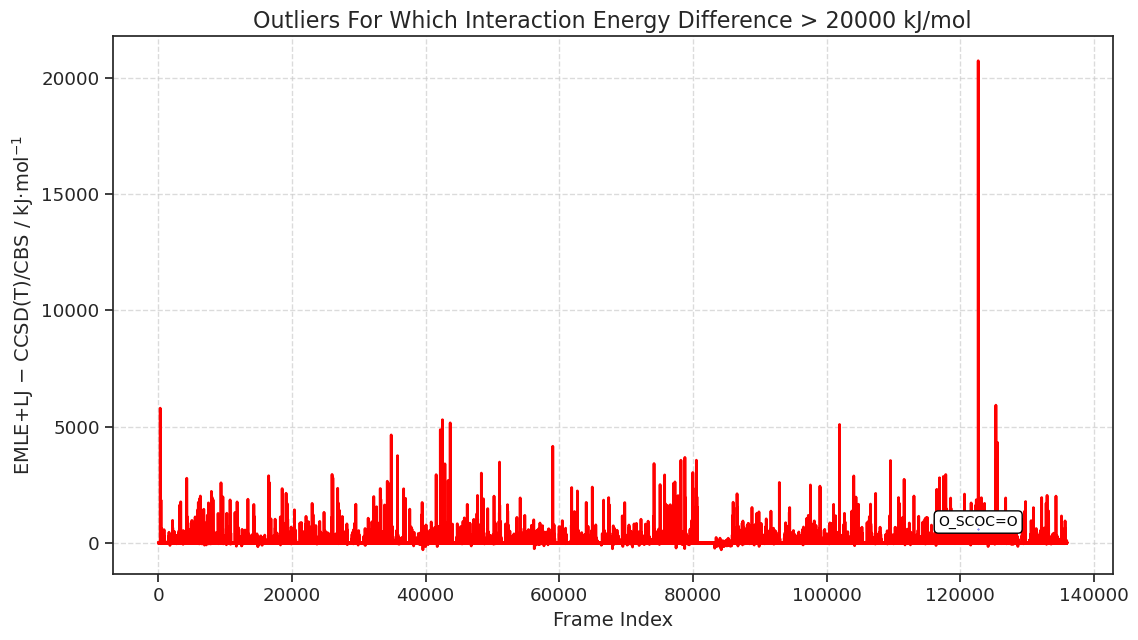

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify outliers
diff = e_int_predicted + e_lj_final - e_int_list
x = np.arange(0, len(e_lj_final))
outliers = x[diff > 20000]
out_list = []

offset = 0
seen = []
for out in outliers:
    for k, v in dataset.items():
        if out > v["frames"][0] and out < v["frames"][-1]:
            if v["name"][0] + "_" + v["name"][1] in seen:
                continue
            else:
                seen.append(v["name"][0] + "_" + v["name"][1])
                offset += 200
            print(k, v["name"][0] + "_" + v["name"][1], out)
            out_list.append([out, 400 + offset, v["name"][0] + "_" + v["name"][1]])

# Set the Seaborn style for a clean look
sns.set(style="ticks", palette="muted", font_scale=1.2)

# Create a figure and axis
plt.figure(figsize=(12, 7))

# Plot the energy values as a line plot
#plt.plot(e_int_predicted + e_lj_initial, label='Initial', color='green', linewidth=2)
plt.plot(diff, label='Target', color='red', linewidth=2)

# Highlight the outliers with scatter points
outlier_x = [o[0] for o in out_list]
outlier_y = [o[1] for o in out_list]
plt.scatter(outlier_x, outlier_y, color='blue', marker='o', s=0.1, label='Outliers', zorder=5)

# Add labels and title
plt.xlabel('Frame Index', fontsize=14)
plt.ylabel('EMLE+LJ − CCSD(T)/CBS / kJ·mol$^{-1}$', fontsize=14)
plt.title('Outliers For Which Interaction Energy Difference > 20000 kJ/mol', fontsize=16)

# Add text annotations with a bounding box for visibility
for out in out_list:
    plt.text(out[0], out[1], f'{out[2]:s}', fontsize=10, color='black', 
             ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend to the plot
#plt.legend(loc='best', fontsize=12)

# Show the plot with adjusted layout
plt.tight_layout(pad=2.0)
plt.show()


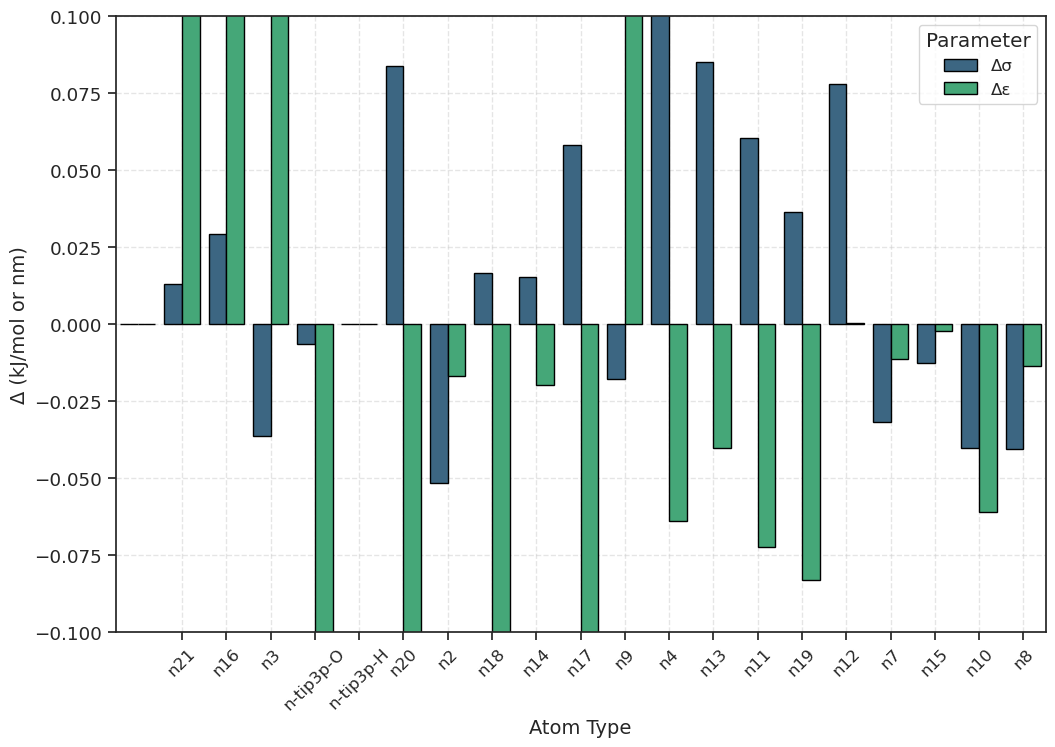

In [ ]:

sigma_init = lj_potential._sigma_init.detach().cpu().numpy().squeeze()
sigma_final = lj_potential._sigma.detach().cpu().numpy().squeeze()
epsilon_init = lj_potential._epsilon_init.detach().cpu().numpy().squeeze() 
epsilon_final = lj_potential._epsilon.detach().cpu().numpy().squeeze()

# Example data (replace with your data)
atom_indices = np.arange(len(sigma_init))
delta_sigma = sigma_final - sigma_init  # Change in sigma
delta_epsilon = epsilon_final - epsilon_init  # Change in epsilon

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    'Atom Index': np.tile(atom_indices, 2),
    'Δ': np.concatenate([delta_sigma, delta_epsilon]),
    'Parameter': ['Δσ'] * len(atom_indices) + ['Δε'] * len(atom_indices)
})

plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='Atom Index', y='Δ', hue='Parameter', palette="viridis", edgecolor='black')
plt.xlabel("Atom Type", fontsize=14)
plt.ylabel("Δ (kJ/mol or nm)", fontsize=14)

atom_type_to_index = lj_potential._atom_type_to_index
index_to_atom_type = {v: k for k, v in atom_type_to_index.items()}
atom_types = [index_to_atom_type[i+1] for i in range(len(index_to_atom_type))]
plt.xticks(ticks=np.arange(len(atom_types))+1, labels=atom_types, fontsize=12, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Parameter", fontsize=12)
plt.ylim(-0.1, 0.1)
plt.show()

In [ ]:
"""
with open("/home/joaomorado/repos/emle-bespoke/utils/DES370K.pkl", "rb") as f:
    results = pickle.load(f)
with open("/home/joaomorado/repos/emle-bespoke/utils/dataset-water.pkl", "rb") as f:
    dataset = pickle.load(f)
"""

'\nwith open("/home/joaomorado/repos/emle-bespoke/utils/DES370K.pkl", "rb") as f:\n    results = pickle.load(f)\nwith open("/home/joaomorado/repos/emle-bespoke/utils/dataset-water.pkl", "rb") as f:\n    dataset = pickle.load(f)\n'

109714 110327


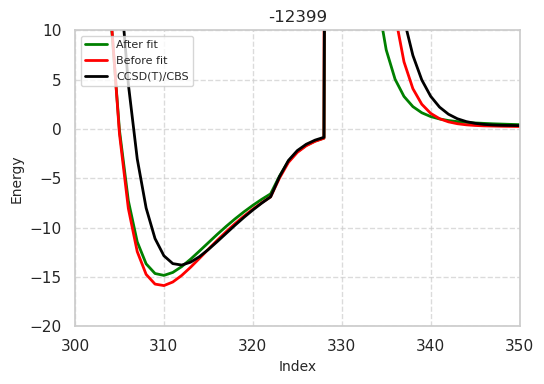

In [ ]:
df = pd.read_csv('/home/joaomorado/repos/emle-bespoke/utils/DES370K.csv')
subset = {k: v for k, v in dataset.items() if k in [12399]}
#subset = dataset
num_systems = len(subset)
cols =  3# Number of columns
rows = int(np.ceil(num_systems / cols)) 

# Set the Seaborn style for a clean look
sns.set(style="whitegrid", palette="muted")

# Create a figure and axes for the 3xN grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=False, sharey=False)

# Flatten axes array for easier iteration
axes = axes.flatten()
# Loop through systems in the dataset
for i, (system_id, values) in enumerate(subset.items()):
    # Get the corresponding axis
    ax = axes[i]

    # Define x limits based on frame IDs
    x_min = values["frames"][0]

    x_max = values["frames"][-1]
    print(x_min, x_max)

    # Define y limits based on e_int_list values for these frames
    y_min = min(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max]) - 15
    y_max = max(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max]) + 5

    # Plot the energy values as a line plot
    ax.plot(e_int_predicted[x_min:x_max] + e_lj_final[x_min:x_max], label='After fit', color='green', linewidth=2)
    ax.plot(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max], label='Before fit', color='red', linewidth=2)
    ax.plot(e_int_list[x_min:x_max], label='CCSD(T)/CBS', color='black', linewidth=2)

    # Add labels and title
    ax.set_xlabel('Index', fontsize=10)
    ax.set_ylabel('Energy', fontsize=10)
    try:
        title = df[df["system_id"] == system_id]["system_name"].values[0]
    except:
        title = ""
    
    ax.set_title(f'{title}-{system_id}', fontsize=12)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    #ax.set_xlim(x_min, x_max)
    ax.set_ylim(-20, 10)
    ax.set_xlim(300, 350)

    # Add a legend to the plot
    ax.legend(fontsize=8, loc='upper left')

# Hide unused subplots if any
for j in range(num_systems, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the grid of plots
plt.show()

In [ ]:
#e_lj_final = e_lj_final.cpu().numpy()
#e_lj_initial = e_lj_initial.cpu().numpy()
e_int = e_int.cpu().numpy()



RMSE Initial LJ: 235.69 kJ/mol
RMSE Final LJ: 122.76 kJ/mol
MSE Initial LJ: 26.24 kJ/mol
MSE Final LJ: 13.79 kJ/mol
R^2 Initial LJ: -54.52
R^2 Final LJ: -14.06


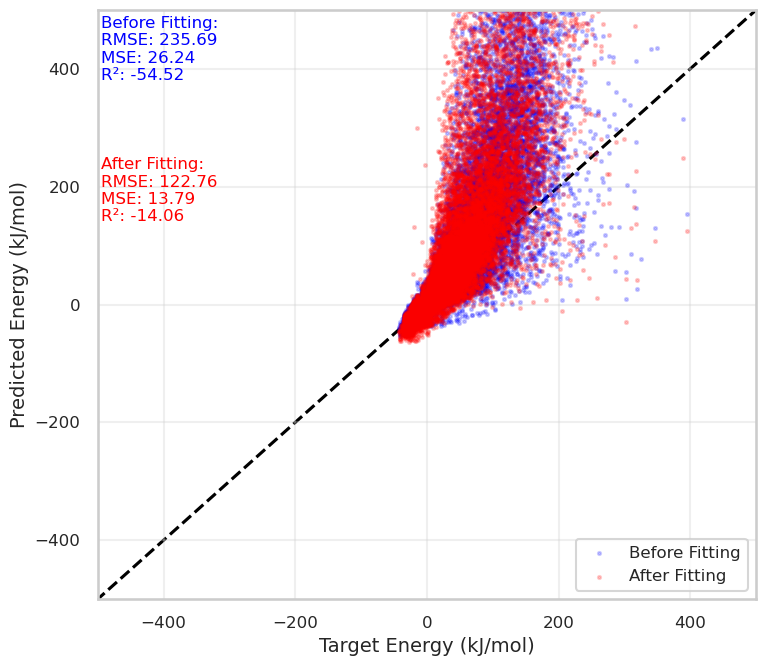

In [ ]:
x=500

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(8, 7))
plt.plot([-1000, 1000], [-1000, 1000], color='black', linestyle='--', zorder=-10)
e_final = e_int_predicted + e_lj_final
e_initial = e_int_predicted + e_lj_initial
mask = e_int < 1e32   
#mask = [frame for frame in dataset[12399]["frames"]][300:320]

plt.scatter(e_int[mask], e_final[mask], color='blue', alpha=0.2, label='Before Fitting', s=5)
plt.scatter(e_int[mask], e_initial[mask], color='red', alpha=0.2, label='After Fitting', s=5)

# Define RMSE, MSE, and R^2 functions
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_signed_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate metrics for initial and final LJ energies
rmse_initial = rmse(e_int[mask], e_int_predicted[mask] + e_lj_initial[mask])
rmse_final = rmse(e_int[mask], e_int_predicted[mask] + e_lj_final[mask])
mse_initial = mean_signed_error(e_int[mask], e_int_predicted[mask] + e_lj_initial[mask])
mse_final = mean_signed_error(e_int[mask], e_int_predicted[mask] + e_lj_final[mask])
r2_initial = r_squared(e_int[mask], e_int_predicted[mask] + e_lj_initial[mask])
r2_final = r_squared(e_int[mask], e_int_predicted[mask] + e_lj_final[mask])


print(f"RMSE Initial LJ: {rmse_initial:.2f} kJ/mol")
print(f"RMSE Final LJ: {rmse_final:.2f} kJ/mol")
print(f"MSE Initial LJ: {mse_initial:.2f} kJ/mol")
print(f"MSE Final LJ: {mse_final:.2f} kJ/mol")
print(f"R^2 Initial LJ: {r2_initial:.2f}")
print(f"R^2 Final LJ: {r2_final:.2f}")

# Add identity line for reference

# Add RMSE, MSE, and R^2 values to the plot
plt.text(-x + 5, x - 10, f"Before Fitting:\nRMSE: {rmse_initial:.2f}\nMSE: {mse_initial:.2f}\nR²: {r2_initial:.2f}", 
         fontsize=12, color='blue', ha='left', va='top')
plt.text(-x + 5, x - 250, f"After Fitting:\nRMSE: {rmse_final:.2f}\nMSE: {mse_final:.2f}\nR²: {r2_final:.2f}", 
         fontsize=12, color='red', ha='left', va='top')

# Labels and title
plt.xlabel("Target Energy (kJ/mol)", fontsize=14)
plt.ylabel("Predicted Energy (kJ/mol)", fontsize=14)

# Legend and grid
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3)

# Adjust ticks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-x, x)
plt.ylim(-x, x)

# Show plot
plt.tight_layout()
plt.show()
